# Summary

- Imports

### Energy Efficiency (appartment level with cross-validation)
- Load Energy Predictions
- Preprocess Target
- LGBM
- Tabnet
- Compare Feature importance

### Fusion approaches
- Late Fusion


# Imports

In [1]:
!pip install pyaxis
!pip install lightgbm
#!pip install pytorch-tabnet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.0/798.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyaxis: filename=pyaxis-0.3.4-py3-none-any.whl size=10752 sha256=062a99db584cc0164c8b94d9520fcdcd125b0c06cf6297afd30132b6426a023c
  Stored in directory: /root/.cache/pip/wheels/af/42/c1/45e30307b7427b61883d3e290fa2fe8661d8a1f03162cbef14
  Created wheel for pyjstat: filename=pyjstat-2.4.0-py3-none-any.whl size=22763 sha256=a77d4f49991109c95fc9b0c76b91c8a8ff11d40e996dc4269fc749e85bdac585
  Stored in directory: /root/.cache/pip/wheels/14/22/83/5d10b2446d66e85756b014a01e987a950124f15e39ff87328e
Successfully built pyaxis pyjstat


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Tabular_Predictions/tabular/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1agmshs1f-vqB9THAUdy-SCK0G2XuIcAu/Tabular_Predictions/tabular


In [3]:
import pandas as pd
import numpy as np
#from pyaxis import pyaxis
from sklearn.metrics import mean_squared_error
from preprocessing_helper import *
from preprocessing import *
from predicting_helpers import *
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from preprocessing_helper import *
from sklearn.model_selection import train_test_split
from helper import *
from sklearn.model_selection import GroupKFold, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import pickle

# Preprocess Target

### Select Parameters here for LGBM

In [4]:
# Select target (note it is set to PropertyFE by default)

# 5 different targets
#target = "Price Gross Normalized" # PropertyFE, demand, Price Net Normalized, Rent Gap, Other Amenities, Price Extra Normalized
#target = "Price Extra Normalized"
#target = "Price Net Normalized" # Note that this doesn't work right now
#target = "Demand"
target = "PropertyFE"

# On cluster or not
cluster = False # True

# cross-validation
n_splits = 5 # set to 1 if you don't want to apply cross-validation

# train-test split
test_size = 0.15

""" LGBM hyperparameters """
# Hyperparameters to test
learning_rate_opts = [0.01]  # , 0.05, 0.01, 0.001, 0.0001
max_leaf_nodes_opts = [20]  # , 25, 30, 35, 40, 50, 60, 80, 100
max_iter_opts = [100]  # , 75, 100, 150, 200, 300, 400, 500, 750, 1000
max_depth_opts = [None]  # , 50, 75, 100, 300, 800


### Preprocess and Prediction function

In [5]:
def preprocess_tab(train_datatab, test_datatab, target="PropertyFE", max_iter=100, max_leaf_nodes=31, learning_rate=0.1,
                      max_depth=None, drop_correlated=False, number_of_apartments_df=None,
                      use_num_appt=False, drop_boolean=False, verbose=True):
    if verbose:
        print('Starting preprocessing of tabular data......')

    # Ensure no overlapping Property Reference IDs between train and test sets
    train_property_ids = set(train_datatab['Property Reference Id'])
    test_property_ids = set(test_datatab['Property Reference Id'])
    y_test = test_datatab[target]

    overlapping_ids = train_property_ids.intersection(test_property_ids)

    if overlapping_ids:
        if verbose:
            print(f'Removing {len(overlapping_ids)} overlapping Property Reference Ids from the test set.')
        test_datatab = test_datatab[~test_datatab['Property Reference Id'].isin(overlapping_ids)]

    if drop_correlated:
        # Drop the columns Number Of Rooms Cleaned and Livingspace
        train_datatab = train_datatab.drop(['Number Of Rooms Cleaned', 'Livingspace'], axis=1)
        test_datatab = test_datatab.drop(['Number Of Rooms Cleaned', 'Livingspace'], axis=1)

    if use_num_appt:
        # Merge the listings data with the number of apartments data
        total_train_datatab = merge_numbappt(train_datatab, number_of_apartments_df)
        total_test_datatab = merge_numbappt(test_datatab, number_of_apartments_df)
        # Convert Number of apartments to float
        total_train_datatab['Number of apartments'] = total_train_datatab['Number of apartments'].astype(float)
        total_test_datatab['Number of apartments'] = total_test_datatab['Number of apartments'].astype(float)
    else:
        total_train_datatab = train_datatab.copy()
        total_test_datatab = test_datatab.copy()

    # Rename a column for clearness
    total_train_datatab.rename(columns={'Leerwohnungsziffer': 'Vacancy rate provided'}, inplace=True)
    total_test_datatab.rename(columns={'Leerwohnungsziffer': 'Vacancy rate provided'}, inplace=True)

    # convert Vacancy rate provided to float
    total_train_datatab['Vacancy rate provided'] = total_train_datatab['Vacancy rate provided'].astype(float)
    total_test_datatab['Vacancy rate provided'] = total_test_datatab['Vacancy rate provided'].astype(float)

    # Adjust for zipcodes that are in the test data but not in the training data
    total_test_datatab = not_in_train(total_test_datatab, total_train_datatab)

    train_datatab_prepr, y_train = preprocessed(total_train_datatab, target, drop_boolean=drop_boolean, split=False)
    test_datatab_prepr = preprocessed(total_test_datatab, target, drop_boolean=drop_boolean, split=False, test_X=True)

    # Adjust for zipcodes that are in the training data but not in the test data
    test_datatab_prepr = not_in_test(total_test_datatab, total_train_datatab, test_datatab_prepr, train_datatab_prepr)

    if target == "PropertyFE":
        train_datatab_prepr = train_datatab_prepr.drop(['Demand'], axis=1)
        test_datatab_prepr = test_datatab_prepr.drop(['Demand'], axis=1)

    if verbose:
        print('Finished preprocessing of tabular data, ready to start predictions......')

    return train_datatab_prepr, y_train, test_datatab_prepr, y_test


In [6]:
# Set the seed
np.random.seed(42)

def preprocessed(listings_df, target="PropertyFE", split=True, test_size=0.2, drop_boolean=False, test_X=False, verbose=False):
    # apartments where either Price Net Normalized or Price Gross Normalized is 1, set them both to Nan
    listings_df.loc[listings_df['Price Net Normalized'] == 1, 'Price Gross Normalized'] = np.nan
    listings_df.loc[listings_df['Price Net Normalized'] == 1, 'Price Net Normalized'] = np.nan
    listings_df.loc[listings_df['Price Gross Normalized'] == 1, 'Price Gross Normalized'] = np.nan
    #listings_df = listings_df.drop(['Price Net Normalized', 'Jahr'], axis=1)
    listings_df = listings_df.drop(['Jahr'], axis=1)


    ###########
    # go to preprocessing_helper.py
    ###########

    print("I'm updating")
    if test_X & ('Prediction' in listings_df.columns):
    # Drop Prediction column
        listings_df = listings_df.drop(['Prediction'], axis=1)
    if not test_X:
        y = listings_df.loc[:, target]
        # Drop target variable from the dataframe and drop text columns
        print("target = ", target)
        listings_df = listings_df.drop([target], axis=1)

    if not test_X:
        listings_df.drop(
                ['Listing Title', 'Listing Description', 'Property Reference Id'], axis=1, inplace=True)

    # Make numerical variables
    listings_df, cantons, subcategories, floors, boolean_columns, zips = make_numerical(listings_df, drop_booleans=drop_boolean)
    if verbose:
        print("Values are now numerical")

    # Add crossterm is renovated * Years since renovated and drop the original renovation column
    listings_df['Is Renovated * Years Since Renovation'] = listings_df['Is Renovated'] * listings_df['Years Since Renovation']
    listings_df.drop(['Years Since Renovation'], axis=1, inplace=True)

    if verbose:
        print('Crossterm is renovated * Years since renovated is added')

    if split and not test_X:
        # Add a column with target to the listing dataframe
        listings_df[target] = y.values
        return split_data(listings_df, test_size=test_size)

    if test_X:
        return listings_df
    return listings_df, y

In [7]:
    # run on cluster?
    cluster = False

    if cluster:
        PATH_IDS_TRAIN = '/work/FAC/HEC/DEEP/shoude/ml_green_building/Data/reference_ids_train.npy'
        PATH_IDS_TEST = '/work/FAC/HEC/DEEP/shoude/ml_green_building/Data/reference_ids_test.npy'
        PATH_DF = '/work/FAC/HEC/DEEP/shoude/ml_green_building/Data/df_full_german.pkl'
        PATH_NUM_APPT = r'/work/FAC/HEC/DEEP/shoude/ml_green_building/Data/vacancy_rate.px'
        PATH_SAVE = '/work/FAC/HEC/DEEP/shoude/ml_green_building/Data/Predictions/prediction_tabular.pkl'
    else:
        PATH_IDS_TRAIN = '/content/drive/MyDrive/Tabular_Predictions/tab_data/reference_ids_train.npy'
        PATH_IDS_TEST = '/content/drive/MyDrive/Tabular_Predictions/tab_data/reference_ids_test.npy'
        PATH_DF = '/content/drive/MyDrive/Tabular_Predictions/tab_data/df_full_german.pkl'
        PATH_NUM_APPT = '/content/drive/MyDrive/Tabular_Predictions/tab_data/vacancy_rate.px'
        PATH_SAVE = '/content/drive/MyDrive/Tabular_Predictions/tab_data/prediction_tabular.pkl'
        Listings_pickle = '/content/drive/MyDrive/Tabular_Predictions/tab_data/listings_full.pkl'
        FE_listings_path = '/content/drive/MyDrive/Tabular_Predictions/tab_data/Listings_FE.csv'


In [8]:
number_of_apartments_df = pyaxis.parse(uri=PATH_NUM_APPT, encoding='utf-8')

NameError: name 'pyaxis' is not defined

In [ ]:
from sklearn.model_selection import GroupKFold, train_test_split
import numpy as np
import pandas as pd

def preprocess_and_split(df, FE_listings=None, target='PropertyFE', split_strategy="GroupKFold", n_splits=5, test_size=0.15, random_state=42):
    if target == 'PropertyFE':
        np.random.seed(random_state)

        # Ensure FE_listings has unique Advertisement ID and Jahr pairs
        FE_listings_target = FE_listings.groupby(['Advertisement Id', 'Jahr']).agg({'PropertyFE': 'mean'}).reset_index()
        print(FE_listings_target)
        # Ensure unique Advertisement ID and Jahr pairs in df by taking the first instance (if duplicates exist)
        df = df.drop_duplicates(subset=['Advertisement Id', 'Jahr'])

        # Merge listings and FE datasets on Advertisement ID and Jahr
        df_merged = pd.merge(df, FE_listings_target, on=['Advertisement Id', 'Jahr'], how='left')
        df_merged = df_merged.dropna(subset=[target])
        df = df_merged
        print(df)
    else:
        np.random.seed(random_state)
        df = df.dropna(subset=[target])

    # Extract building IDs
    df['Building ID'] = df['Property Reference Id'].str[:4]

    if split_strategy == "GroupKFold":
        if n_splits == 1:
            gkf = GroupKFold(n_splits=2)
            splits = list(gkf.split(df, groups=df['Building ID']))
            #splits = [splits[0]]  # Keep only the first fold
        else:
            gkf = GroupKFold(n_splits=n_splits)
            splits = list(gkf.split(df, groups=df['Building ID']))
    elif split_strategy == "Simple":
        train_idx, test_idx = train_test_split(df.index, test_size=test_size, random_state=random_state, stratify=df['Building ID'])
        splits = [(train_idx, test_idx)]
    else:
        raise ValueError("Unknown split_strategy. Choose 'GroupKFold' or 'Simple'.")

    processed_splits = []

    for fold, (train_idx, test_idx) in enumerate(splits):
        train_datatab = df.iloc[train_idx].copy()
        test_datatab = df.iloc[test_idx].copy()
        test_datatab['Prediction'] = np.nan

        train_datatab_prepr, y_train, test_datatab_prepr, y_test = preprocess_tab(
            train_datatab, test_datatab, target,
            number_of_apartments_df=number_of_apartments_df['DATA'],
            drop_boolean=True, drop_correlated=True, use_num_appt=True,
            max_iter=max_iter_opts, learning_rate=learning_rate_opts,
            max_depth=max_depth_opts, max_leaf_nodes=max_leaf_nodes_opts
        )

        processed_splits.append((fold, train_datatab_prepr, y_train, test_datatab_prepr, y_test))

    # Ensure all splits have the same features
    all_features = set()
    for _, train_datatab_prepr, _, test_datatab_prepr, _ in processed_splits:
        all_features.update(train_datatab_prepr.columns)
        all_features.update(test_datatab_prepr.columns)

    all_features = list(all_features)

    for i, (fold, train_datatab_prepr, y_train, test_datatab_prepr, y_test) in enumerate(processed_splits):
        missing_train_features = set(all_features) - set(train_datatab_prepr.columns)
        missing_test_features = set(all_features) - set(test_datatab_prepr.columns)

        for feature in missing_train_features:
            train_datatab_prepr[feature] = np.nan
        for feature in missing_test_features:
            test_datatab_prepr[feature] = np.nan

        processed_splits[i] = (fold, train_datatab_prepr[all_features], y_train, test_datatab_prepr[all_features], y_test)

    return processed_splits

# Example usage
df = pd.read_pickle(PATH_DF)
df = df.drop([38637, 38703, 39616, 39723, 41209, 41267])

FE_listings = pd.read_csv(FE_listings_path)

# Use GroupKFold with multiple splits
cross_validation_splits = preprocess_and_split(df, FE_listings=FE_listings, split_strategy="GroupKFold", n_splits=5)

# Use GroupKFold with a single split
#cross_validation_splits_single = preprocess_and_split(df, FE_listings=FE_listings, split_strategy="GroupKFold", n_splits=1)

# Use simple train-test split
#cross_validation_splits_simple = preprocess_and_split(df, FE_listings=FE_listings, split_strategy="Simple", test_size=0.2)

# Iterate over the splits and print the results
for fold, train_datatab_prepr, y_train, test_datatab_prepr, y_test in cross_validation_splits:
    print(f"Fold {fold}")
    print(f"train_datatab_prepr {train_datatab_prepr}")
    # print(f"y_test {y_test}")


In [ ]:
# Example usage
df = pd.read_pickle(PATH_DF)
df = df.drop([38637, 38703, 39616, 39723, 41209, 41267])

FE_listings = pd.read_csv(FE_listings_path)

In [ ]:
# Get rid of Zips and Cities

for i, (fold, train_datatab_prepr, y_train, test_datatab_prepr, y_test) in enumerate(cross_validation_splits):
    # Identify columns that start with "Zip" or "City"
    columns_to_drop_1 = [col for col in train_datatab_prepr.columns if col.startswith('Zip')] #  or col.startswith('City')
    columns_to_drop_2 = [col for col in test_datatab_prepr.columns if col.startswith('Zip')] #or col.startswith('City')

    # Drop the identified columns
    train_datatab_prepr = train_datatab_prepr.drop(columns=columns_to_drop_1)
    test_datatab_prepr = test_datatab_prepr.drop(columns=columns_to_drop_2)

    # Update the fold with the modified data
    cross_validation_splits[i] = (fold, train_datatab_prepr, y_train, test_datatab_prepr, y_test)

# Iterate over the splits and print the results to verify
for fold, train_datatab_prepr, y_train, test_datatab_prepr, y_test in cross_validation_splits:
    print(f"Fold {fold}")
    print(f"train_datatab_prepr columns: {train_datatab_prepr.columns}")
    print(f"test_datatab_prepr columns: {test_datatab_prepr.columns}")
    print(f"y_test: {y_test.head()}")




In [11]:

def predict_tab(train_datatab_prepr, y_train, test_datatab_prepr, test_datatab, max_iter=100, max_leaf_nodes=31, learning_rate=0.1,
                max_depth=None, drop_correlated=False, number_of_apartments_df=None,
                use_num_appt=False, drop_boolean=False, verbose=True, return_train=False):
    # Run a hist gradient boosting with default parameters

    # replace Nan in y_train with mean of y_train (there are a few exceptions I couldn't get rid of)
    y_train = y_train.fillna(y_train.mean())

    hist = hist_gradient_boosting_train(train_datatab_prepr, y_train, max_iter=max_iter, max_leaf_nodes=max_leaf_nodes, learning_rate=learning_rate,
                                        max_depth=max_depth, ylog=False)
    hist_pred = hist_gradient_boosting_predict(test_datatab_prepr, hist, ylog=False, train=False)
    if return_train == True:
      hist_pred_train = hist_gradient_boosting_predict(train_datatab_prepr, hist, ylog=False, train=False)
      train_datatab['Prediction'] = hist_pred_train

    test_datatab['Prediction'] = hist_pred


    # Fill the Prediction column with the predictions
    #ind_def = test_datatab[(pd.DatetimeIndex(test_datatab['Day of Advertisement Created']).year < 2017) & (pd.DatetimeIndex(test_datatab['Day of Advertisement Created']).month < 12)].index
    #test_datatab.loc[ind_def, 'Prediction'] = 1e-10

    # Fill the Prediction column with the predictions
    if verbose:
        print('Finished and returned predictions')
    if return_train == True:
        return test_datatab, test_datatab_prepr, hist, train_datatab
    else:
        return test_datatab, test_datatab_prepr, hist




## (***Run up to here for all LGBM related work***)

In [19]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.metrics import mean_squared_error

learning_rates = 0.1 #, 0.05, 0.01]
max_leaf_nodes_opt = 20 #, 30, 50, 60, 80, 100]
max_iter_opt = 50 # 100, 150, 200]
max_depth_opt = None # , 100, 150, 200, 300, 400, 500, 750, 1000


# Function to load a PKL file
def load_pkl(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data

# Function to standardize the format of Property Reference Id
def standardize_property_id(prop_id):
    prop_id = str(prop_id)
    if '.' not in prop_id:
        return f"{prop_id[:4]}.{prop_id[4:6]}.{prop_id[6:]}"
    return prop_id

# Function to instantiate dataframes for each key in the PKL file
def create_dataframes_from_pkl(data):
    dataframes = {}
    for key in data.keys():
        img_fe, adv_id, prop_ref_id = data[key]
        df = pd.DataFrame({
            'img_fe': img_fe,
            'Advertisement Id': adv_id,
            'Property Reference Id': [standardize_property_id(x) for x in prop_ref_id]
        })
        dataframes[key] = df
    return dataframes

# List of PKL files to load
pkl_files = [
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv1.pkl",
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv2.pkl",
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv3.pkl",
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv4.pkl",
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv5.pkl"
]

# Dictionary to hold all dataframes
all_dataframes = {}

# Load and create dataframes for each PKL file
for file in pkl_files:
    if os.path.exists(file):
        cv_num = file.split("_cv")[-1].split(".")[0]  # Extract CV number from filename
        data = load_pkl(file)
        dataframes = create_dataframes_from_pkl(data)
        for key, df in dataframes.items():
            all_dataframes[f"imgs_{key}_cv{cv_num}"] = df
            print(f"DataFrame for imgs_{key}_cv{cv_num} created.")
    else:
        print(f"{file} not found.")

# Function to load a CSV file into a dataframe
def load_csv(filename):
    df = pd.read_csv(filename)
    print(f"DataFrame for {filename} created.")
    return df

# Mapping of numbers in filenames to cv numbers
cv_mapping = {
    '21': 'cv1',
    '22': 'cv2',
    '23': 'cv3',
    '24': 'cv4',
    '25': 'cv5'
}

# List of CSV files to load
csv_files = [
    "results_cross_val/test_predictions_properties21.csv",
    "results_cross_val/test_predictions_properties22.csv",
    "results_cross_val/test_predictions_properties23.csv",
    "results_cross_val/test_predictions_properties24.csv",
    "results_cross_val/test_predictions_properties25.csv",
    "results_cross_val/train_predictions_properties21.csv",
    "results_cross_val/train_predictions_properties22.csv",
    "results_cross_val/train_predictions_properties23.csv",
    "results_cross_val/train_predictions_properties24.csv",
    "results_cross_val/train_predictions_properties25.csv",
    "results_cross_val/val_predictions_properties21.csv",
    "results_cross_val/val_predictions_properties22.csv",
    "results_cross_val/val_predictions_properties23.csv",
    "results_cross_val/val_predictions_properties24.csv",
    "results_cross_val/val_predictions_properties25.csv"
]

# Load and create dataframes for each CSV file with proper naming
for file in csv_files:
    if os.path.exists(file):
        df = load_csv(file)
        # Ensure the column name is consistent
        df.rename(columns={'Property_Reference_Id': 'Property Reference Id', 'Predicted FE': 'text_fe'}, inplace=True)
        # Standardize the Property Reference Id format
        df['Property Reference Id'] = df['Property Reference Id'].apply(standardize_property_id)
        # Drop 'Actual FE' column if present
        if 'Actual FE' in df.columns:
            df = df.drop(columns=['Actual FE'])
        # Aggregate text_fe by taking the average for unique Property Reference Id
        df = df.groupby('Property Reference Id').agg({'text_fe': 'mean'}).reset_index()
        # Extract the key (train, test, val) and cv number from the filename
        key = file.split("/")[-1].split("_")[0]
        num = file.split("/")[-1].split("properties")[-1].split(".")[0]
        cv_num = cv_mapping[num]
        all_dataframes[f"{key}_predictions_{cv_num}"] = df
    else:
        print(f"{file} not found.")

# Function to merge and add img_fe and text_fe
def merge_and_add_features(df_merge, img_df, text_df, merge_keys=['Advertisement Id']):
    print(df_merge.shape, "df_merge", img_df.shape, "img_df", text_df.shape, "text_df")

    # Ensure merge_key is in string format for all dataframes
    for key in merge_keys:
        df_merge[key] = df_merge[key].astype(str)
        img_df[key] = img_df[key].astype(str)
    text_df['Property Reference Id'] = text_df['Property Reference Id'].astype(str)

    # Calculate overlapping Property Reference Ids
    overlap_img = len(set(df_merge[merge_keys[0]]) & set(img_df[merge_keys[0]]))
    overlap_text = len(set(df_merge[merge_keys[0]]) & set(text_df['Property Reference Id']))
    print(f"Overlapping Property Reference Ids with img_df: {overlap_img}")
    print(f"Overlapping Property Reference Ids with text_df: {overlap_text}")

    # Merge df_merge with text_df on 'Property Reference Id'
    merged_df = text_df.merge(df_merge, on='Property Reference Id', how='left')

    # Add img_df regardless of Property Reference Id because they should be the same size
    merged_df = pd.concat([merged_df, img_df[['img_fe', 'Advertisement Id']]], axis=1)

    return merged_df

# Function to calculate RMSE and NMBE
def calculate_final_metrics(predictions, labels):
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    nmbe = np.mean(np.array(predictions) - np.array(labels)) / np.mean(np.array(labels))
    return mse, rmse, nmbe

# Merging and adding features
results = []  # Initialize results list to store results

for cv in ['cv1', 'cv2', 'cv3', 'cv4', 'cv5']:
    # Generate and save train, validation, and test datasets
    train_df = merge_and_add_features(df_merge, all_dataframes[f"imgs_train_{cv}"], all_dataframes[f"train_predictions_{cv}"])
    val_df = merge_and_add_features(df_merge, all_dataframes[f"imgs_val_{cv}"], all_dataframes[f"val_predictions_{cv}"])
    test_df = merge_and_add_features(df_merge, all_dataframes[f"imgs_test_{cv}"], all_dataframes[f"test_predictions_{cv}"])

    # Save the formatted datasets to CSV files
    train_df.to_csv(f"train_cross_val_{cv}.csv", index=False)
    val_df.to_csv(f"val_cross_val_{cv}.csv", index=False)
    test_df.to_csv(f"test_cross_val_{cv}.csv", index=False)

    # Concatenate train and validation sets
    train_datatab = pd.concat([train_df, val_df], axis=0)
    test_datatab = test_df

    train_datatab["img_fe"] = train_datatab["img_fe"].apply(lambda x: float(x[0]) if isinstance(x, list) else float(x))
    test_datatab["img_fe"] = test_datatab["img_fe"].apply(lambda x: float(x[0]) if isinstance(x, list) else float(x))

    train_datatab["Jahr"] = train_datatab["Jahr"].fillna(train_datatab["Jahr"].median()).astype(int)
    test_datatab["Jahr"] = test_datatab["Jahr"].fillna(test_datatab["Jahr"].median()).astype(int)

    # Ensure consistent data types for all columns
    for col in train_datatab.select_dtypes(include=['object']).columns:
        train_datatab[col] = train_datatab[col].astype(str)
    for col in test_datatab.select_dtypes(include=['object']).columns:
        test_datatab[col] = test_datatab[col].astype(str)

    train_datatab = train_datatab.drop(columns=['Advertisement Id'], errors='ignore')
    test_datatab = test_datatab.drop(columns=['Advertisement Id'], errors='ignore')

    # Preprocess the data
    train_datatab_prepr, y_train, test_datatab_prepr, y_test = preprocess_tab(
        train_datatab, test_datatab, target='PropertyFE',
        number_of_apartments_df=None,
        drop_boolean=True, drop_correlated=True, use_num_appt=False,
        max_iter=max_iter_opt, learning_rate=learning_rates,
        max_depth=max_depth_opt, max_leaf_nodes=max_leaf_nodes_opt
    )

    print(train_datatab_prepr.shape, "train_datatab_prepr")
    print(test_datatab_prepr.shape, "test_datatab_prepr")
    print(y_train.shape, "y_train")
    print(y_test.shape, "y_test")

    # Predict the data
    test_datatab_fit, test_datatab_prepr, trained_hist_model, train_datatab_fit = predict_tab(
        train_datatab_prepr, y_train, test_datatab_prepr, test_datatab_prepr,
        number_of_apartments_df=None, drop_boolean=True,
        drop_correlated=True, use_num_appt=False, max_iter=max_iter_opt,
        learning_rate=learning_rates, max_depth=max_depth_opt, max_leaf_nodes=max_leaf_nodes_opt,
        return_train=True
    )

    # Calculate metrics for the test set
    mask = ~y_test.isna()
    mse, rmse, nmbe = calculate_final_metrics(test_datatab_fit['Prediction'][mask], y_test[mask])
    results.append({'cv': cv, 'mse': mse, 'rmse': rmse, 'nmbe': nmbe})
    print(f"Metrics for {cv}: MSE: {mse}, RMSE: {rmse}, NMBE: {nmbe}")

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

# Save the results to a CSV file
results_df.to_csv('results.csv', index=False)


DataFrame for imgs_train_cv1 created.
DataFrame for imgs_val_cv1 created.
DataFrame for imgs_test_cv1 created.
DataFrame for imgs_train_cv2 created.
DataFrame for imgs_val_cv2 created.
DataFrame for imgs_test_cv2 created.
DataFrame for imgs_train_cv3 created.
DataFrame for imgs_val_cv3 created.
DataFrame for imgs_test_cv3 created.
DataFrame for imgs_train_cv4 created.
DataFrame for imgs_val_cv4 created.
DataFrame for imgs_test_cv4 created.
DataFrame for imgs_train_cv5 created.
DataFrame for imgs_val_cv5 created.
DataFrame for imgs_test_cv5 created.
DataFrame for results_cross_val/test_predictions_properties21.csv created.
DataFrame for results_cross_val/test_predictions_properties22.csv created.
DataFrame for results_cross_val/test_predictions_properties23.csv created.
DataFrame for results_cross_val/test_predictions_properties24.csv created.
DataFrame for results_cross_val/test_predictions_properties25.csv created.
DataFrame for results_cross_val/train_predictions_properties21.csv cre

In [27]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor

# Function to load a PKL file
def load_pkl(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data

# Function to standardize the format of Property Reference Id
def standardize_property_id(prop_id):
    prop_id = str(prop_id)
    if '.' not in prop_id:
        return f"{prop_id[:4]}.{prop_id[4:6]}.{prop_id[6:]}"
    return prop_id

# Function to instantiate dataframes for each key in the PKL file
def create_dataframes_from_pkl(data):
    dataframes = {}
    for key in data.keys():
        img_fe, adv_id, prop_ref_id = data[key]
        df = pd.DataFrame({
            'img_fe': img_fe,
            'Advertisement Id': adv_id,
            'Property Reference Id': [standardize_property_id(x) for x in prop_ref_id]
        })
        dataframes[key] = df
    return dataframes

# List of PKL files to load
pkl_files = [
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv1.pkl",
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv2.pkl",
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv3.pkl",
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv4.pkl",
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv5.pkl"
]

# Dictionary to hold all dataframes
all_dataframes = {}

# Load and create dataframes for each PKL file
for file in pkl_files:
    if os.path.exists(file):
        cv_num = file.split("_cv")[-1].split(".")[0]  # Extract CV number from filename
        data = load_pkl(file)
        dataframes = create_dataframes_from_pkl(data)
        for key, df in dataframes.items():
            all_dataframes[f"imgs_{key}_cv{cv_num}"] = df
            print(f"DataFrame for imgs_{key}_cv{cv_num} created.")
    else:
        print(f"{file} not found.")

# Function to load a CSV file into a dataframe
def load_csv(filename):
    df = pd.read_csv(filename)
    print(f"DataFrame for {filename} created.")
    return df

# Mapping of numbers in filenames to cv numbers
cv_mapping = {
    '21': 'cv1',
    '22': 'cv2',
    '23': 'cv3',
    '24': 'cv4',
    '25': 'cv5'
}

# List of CSV files to load
csv_files = [
    "results_cross_val/test_predictions_properties21.csv",
    "results_cross_val/test_predictions_properties22.csv",
    "results_cross_val/test_predictions_properties23.csv",
    "results_cross_val/test_predictions_properties24.csv",
    "results_cross_val/test_predictions_properties25.csv",
    "results_cross_val/train_predictions_properties21.csv",
    "results_cross_val/train_predictions_properties22.csv",
    "results_cross_val/train_predictions_properties23.csv",
    "results_cross_val/train_predictions_properties24.csv",
    "results_cross_val/train_predictions_properties25.csv",
    "results_cross_val/val_predictions_properties21.csv",
    "results_cross_val/val_predictions_properties22.csv",
    "results_cross_val/val_predictions_properties23.csv",
    "results_cross_val/val_predictions_properties24.csv",
    "results_cross_val/val_predictions_properties25.csv"
]

# Load and create dataframes for each CSV file with proper naming
for file in csv_files:
    if os.path.exists(file):
        df = load_csv(file)
        # Ensure the column name is consistent
        df.rename(columns={'Property_Reference_Id': 'Property Reference Id', 'Predicted FE': 'text_fe'}, inplace=True)
        # Standardize the Property Reference Id format
        df['Property Reference Id'] = df['Property Reference Id'].apply(standardize_property_id)
        # Drop 'Actual FE' column if present
        if 'Actual FE' in df.columns:
            df = df.drop(columns=['Actual FE'])
        # Aggregate text_fe by taking the average for unique Property Reference Id
        df = df.groupby('Property Reference Id').agg({'text_fe': 'mean'}).reset_index()
        # Extract the key (train, test, val) and cv number from the filename
        key = file.split("/")[-1].split("_")[0]
        num = file.split("/")[-1].split("properties")[-1].split(".")[0]
        cv_num = cv_mapping[num]
        all_dataframes[f"{key}_predictions_{cv_num}"] = df
    else:
        print(f"{file} not found.")

# Function to merge and add img_fe and text_fe
def merge_and_add_features(df_merge, img_df, text_df, merge_keys=['Advertisement Id']):
    print(df_merge.shape, "df_merge", img_df.shape, "img_df", text_df.shape, "text_df")

    # Ensure merge_key is in string format for all dataframes
    for key in merge_keys:
        df_merge[key] = df_merge[key].astype(str)
        img_df[key] = img_df[key].astype(str)
    text_df['Property Reference Id'] = text_df['Property Reference Id'].astype(str)

    # Merge df_merge with text_df on 'Property Reference Id'
    merged_df = text_df.merge(df_merge, on='Property Reference Id', how='left')

    # Add img_df regardless of Property Reference Id because they should be the same size
    merged_df = pd.concat([merged_df, img_df[['img_fe', 'Advertisement Id']]], axis=1)

    return merged_df

# Function to calculate RMSE and NMBE
def calculate_final_metrics(predictions, labels):
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    nmbe = np.mean(np.array(predictions) - np.array(labels)) / np.mean(np.array(labels))
    return mse, rmse, nmbe

# Merging and adding features
results = []  # Initialize results list to store results

for cv in ['cv1', 'cv2', 'cv3', 'cv4', 'cv5']:
    # Generate and save train, validation, and test datasets
    train_df = merge_and_add_features(df_merge, all_dataframes[f"imgs_train_{cv}"], all_dataframes[f"train_predictions_{cv}"])
    val_df = merge_and_add_features(df_merge, all_dataframes[f"imgs_val_{cv}"], all_dataframes[f"val_predictions_{cv}"])
    test_df = merge_and_add_features(df_merge, all_dataframes[f"imgs_test_{cv}"], all_dataframes[f"test_predictions_{cv}"])

    # Save the formatted datasets to CSV files
    train_df.to_csv(f"train_cross_val_{cv}.csv", index=False)
    val_df.to_csv(f"val_cross_val_{cv}.csv", index=False)
    test_df.to_csv(f"test_cross_val_{cv}.csv", index=False)

    # Concatenate train and validation sets
    train_datatab = pd.concat([train_df, val_df], axis=0)
    test_datatab = test_df

    train_datatab["img_fe"] = train_datatab["img_fe"].apply(lambda x: float(x[0]) if isinstance(x, list) else float(x))
    test_datatab["img_fe"] = test_datatab["img_fe"].apply(lambda x: float(x[0]) if isinstance(x, list) else float(x))

    train_datatab["Jahr"] = train_datatab["Jahr"].fillna(train_datatab["Jahr"].median()).astype(int)
    test_datatab["Jahr"] = test_datatab["Jahr"].fillna(test_datatab["Jahr"].median()).astype(int)

    # Ensure consistent data types for all columns
    for col in train_datatab.select_dtypes(include=['object']).columns:
        train_datatab[col] = train_datatab[col].astype(str)
    for col in test_datatab.select_dtypes(include=['object']).columns:
        test_datatab[col] = test_datatab[col].astype(str)

    train_datatab = train_datatab.drop(columns=['Advertisement Id'], errors='ignore')
    test_datatab = test_datatab.drop(columns=['Advertisement Id'], errors='ignore')

    # Preprocess the data
    train_datatab_prepr, y_train, test_datatab_prepr, y_test = preprocess_tab(
        train_datatab, test_datatab, target='PropertyFE',
        number_of_apartments_df=None,
        drop_boolean=True, drop_correlated=True, use_num_appt=False,
        max_iter=max_iter_opt, learning_rate=learning_rates,
        max_depth=max_depth_opt, max_leaf_nodes=max_leaf_nodes_opt
    )

    print(train_datatab_prepr.shape, "train_datatab_prepr")
    print(test_datatab_prepr.shape, "test_datatab_prepr")
    print(y_train.shape, "y_train")
    print(y_test.shape, "y_test")

    # Predict using the LGBM model with tabular data only
    model = LGBMRegressor(
        n_estimators=max_iter_opt,
        learning_rate=learning_rates,
        max_depth=max_depth_opt,
        num_leaves=max_leaf_nodes_opt
    )
    model.fit(train_datatab_prepr, y_train)
    lgbm_predictions = model.predict(test_datatab_prepr)
    test_datatab_fit = test_datatab_prepr.copy()
    test_datatab_fit['lgbm_pred'] = lgbm_predictions

    # Filter out NaN values in y_test and corresponding rows in predictions
    valid_mask = ~y_test.isna()
    y_test_filtered = y_test[valid_mask]
    test_datatab_fit_filtered = test_datatab_fit[valid_mask]

    # Average fusion
    test_datatab_fit_filtered['avg_fusion'] = test_datatab_fit_filtered[['lgbm_pred', 'text_fe', 'img_fe']].mean(axis=1)
    mse_avg, rmse_avg, nmbe_avg = calculate_final_metrics(test_datatab_fit_filtered['avg_fusion'], y_test_filtered)
    results.append({'cv': cv, 'fusion_type': 'average', 'mse': mse_avg, 'rmse': rmse_avg, 'nmbe': nmbe_avg})
    print(f"Average Fusion Metrics for {cv}: MSE: {mse_avg}, RMSE: {rmse_avg}, NMBE: {nmbe_avg}")

    # Imputation and ElasticNet fusion
    imputer = SimpleImputer(strategy='mean')
    fusion_data = test_datatab_fit_filtered[['lgbm_pred', 'text_fe', 'img_fe']]
    fusion_data_imputed = imputer.fit_transform(fusion_data)
    fusion_model = ElasticNet()
    fusion_model.fit(fusion_data_imputed, y_test_filtered)
    en_predictions = fusion_model.predict(fusion_data_imputed)
    mse_en, rmse_en, nmbe_en = calculate_final_metrics(en_predictions, y_test_filtered)
    results.append({'cv': cv, 'fusion_type': 'elasticnet', 'mse': mse_en, 'rmse': rmse_en, 'nmbe': nmbe_en})
    print(f"ElasticNet Fusion Metrics for {cv}: MSE: {mse_en}, RMSE: {rmse_en}, NMBE: {nmbe_en}")

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

# Save the results to a CSV file
results_df.to_csv('fusion_results.csv', index=False)


DataFrame for imgs_train_cv1 created.
DataFrame for imgs_val_cv1 created.
DataFrame for imgs_test_cv1 created.
DataFrame for imgs_train_cv2 created.
DataFrame for imgs_val_cv2 created.
DataFrame for imgs_test_cv2 created.
DataFrame for imgs_train_cv3 created.
DataFrame for imgs_val_cv3 created.
DataFrame for imgs_test_cv3 created.
DataFrame for imgs_train_cv4 created.
DataFrame for imgs_val_cv4 created.
DataFrame for imgs_test_cv4 created.
DataFrame for imgs_train_cv5 created.
DataFrame for imgs_val_cv5 created.
DataFrame for imgs_test_cv5 created.
DataFrame for results_cross_val/test_predictions_properties21.csv created.
DataFrame for results_cross_val/test_predictions_properties22.csv created.
DataFrame for results_cross_val/test_predictions_properties23.csv created.
DataFrame for results_cross_val/test_predictions_properties24.csv created.
DataFrame for results_cross_val/test_predictions_properties25.csv created.
DataFrame for results_cross_val/train_predictions_properties21.csv cre

In [7]:
import pandas as pd
import numpy as np

# Function to standardize the format of Property Reference Id
def standardize_property_id(prop_id):
    prop_id = str(prop_id)
    if '.' not in prop_id:
        return f"{prop_id[:4]}.{prop_id[4:6]}.{prop_id[6:]}"
    return prop_id

# Define a function to calculate NMBE
def calculate_nmbe(predictions, actuals):
    mask = ~actuals.isna()  # Remove NaN values
    return np.mean(predictions[mask] - actuals[mask]) / np.mean(actuals[mask])

# Define the list of test CSV files
test_csv_files = [
    "results_cross_val/test_predictions_properties21.csv",
    "results_cross_val/test_predictions_properties22.csv",
    "results_cross_val/test_predictions_properties23.csv",
    "results_cross_val/test_predictions_properties24.csv",
    "results_cross_val/test_predictions_properties25.csv"
]

# Initialize a list to store NMBE values
nmbe_values = []

# Loop through each file, calculate NMBE, and store the result
for file in test_csv_files:
    df = pd.read_csv(file)
    df.rename(columns={'Property_Reference_Id': 'Property Reference Id', 'Predicted FE': 'text_fe'}, inplace=True)
    df['Property Reference Id'] = df['Property Reference Id'].apply(standardize_property_id)

    if 'Actual FE' in df.columns:
        actuals = df['Actual FE']
        predictions = df['text_fe']
        nmbe = calculate_nmbe(predictions, actuals)
        nmbe_values.append(nmbe)
        print(f"NMBE for {file}: {nmbe}")
    else:
        print(f"Actual FE column not found in {file}.")


NMBE for results_cross_val/test_predictions_properties21.csv: 0.07563629493035912
NMBE for results_cross_val/test_predictions_properties22.csv: 0.04963025205071678
NMBE for results_cross_val/test_predictions_properties23.csv: 0.036679843274061756
NMBE for results_cross_val/test_predictions_properties24.csv: -0.01668572049445285
NMBE for results_cross_val/test_predictions_properties25.csv: 0.040432152274120246


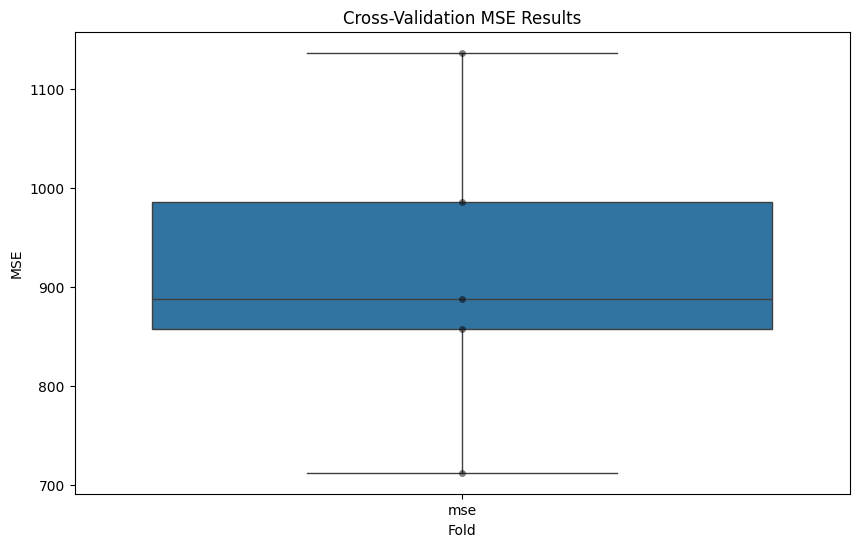

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming mse_results_df has columns for each fold's results
plt.figure(figsize=(10, 6))
sns.boxplot(data=mse_results_df)
sns.swarmplot(data=mse_results_df, color='black', alpha=0.5)

plt.title('Cross-Validation MSE Results')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.show()

In [162]:
y_test.isna().sum()

75

In [148]:

duplicate_columns = test_datatab_prepr.columns[test_datatab_prepr.columns.duplicated()].unique()
print(f"Duplicate columns in test_datatab_prepr: {duplicate_columns}")

Duplicate columns in test_datatab_prepr: Index(['Advertisement Id'], dtype='object')


# LGBM

### Implement LGBM with cross-validation

In [38]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle
import pandas as pd

# Dictionary to store MSE, RMSE, and NMBE scores for each hyperparameter combination
metrics_scores = {}

# Loop over hyperparameters
for learning_rate_opt in learning_rate_opts:
    for max_leaf_nodes_opt in max_leaf_nodes_opts:
        for max_iter_opt in max_iter_opts:
            for max_depth_opt in max_depth_opts:
                # Initialize lists to store scores for cross-validation splits
                fold_mse_scores = []
                fold_rmse_scores = []
                fold_nmbe_scores = []

                cross_val = cross_validation_splits.copy()

                # Loop over cross-validation splits
                for fold, train_datatab_prepr, y_train, test_datatab_prepr, y_test in cross_val:
                    print(f"Fold {fold}, learning_rate: {learning_rate_opt}, max_leaf_nodes: {max_leaf_nodes_opt}, max_iter: {max_iter_opt}, max_depth: {max_depth_opt}")

                    # Ensure consistent feature names by removing 'Prediction' column from test data if present
                    if 'Prediction' in test_datatab_prepr.columns:
                        test_datatab_prepr = test_datatab_prepr.drop(columns=['Prediction'])

                    test_datatab_fit, test_datatab_prepr, trained_hist_model = predict_tab(
                        train_datatab_prepr, y_train, test_datatab_prepr, test_datatab_prepr,
                        number_of_apartments_df=number_of_apartments_df['DATA'], drop_boolean=True,
                        drop_correlated=True, use_num_appt=True, max_iter=max_iter_opt,
                        learning_rate=learning_rate_opt, max_depth=max_depth_opt, max_leaf_nodes=max_leaf_nodes_opt
                    )

                    predictions = test_datatab_fit['Prediction']
                    mse = mean_squared_error(predictions, y_test)
                    rmse = np.sqrt(mse)
                    nmbe = np.mean(predictions - y_test) / np.mean(y_test)

                    fold_mse_scores.append(mse)
                    fold_rmse_scores.append(rmse)
                    fold_nmbe_scores.append(nmbe)
                    print(f"MSE on fold {fold} test set: {mse}, RMSE: {rmse}, NMBE: {nmbe}")

                # Average metrics across folds
                avg_mse = np.mean(fold_mse_scores)
                avg_rmse = np.mean(fold_rmse_scores)
                avg_nmbe = np.mean(fold_nmbe_scores)
                hyperparams = (learning_rate_opt, max_leaf_nodes_opt, max_iter_opt, max_depth_opt)
                metrics_scores[hyperparams] = {'mse': avg_mse, 'rmse': avg_rmse, 'nmbe': avg_nmbe}

                print(f"Average metrics for learning_rate: {learning_rate_opt}, max_leaf_nodes: {max_leaf_nodes_opt}, max_iter: {max_iter_opt}, max_depth: {max_depth_opt}: MSE: {avg_mse}, RMSE: {avg_rmse}, NMBE: {avg_nmbe}")

# Save the overall results
with open(PATH_SAVE, 'wb') as f:
    pickle.dump(metrics_scores, f)

# Prepare data for heatmap or other visualization
heatmap_data = []
for hyperparams, metrics in metrics_scores.items():
    heatmap_data.append([*hyperparams, metrics['mse'], metrics['rmse'], metrics['nmbe']])

# Convert to DataFrame
df_heatmap = pd.DataFrame(heatmap_data, columns=['learning_rate', 'max_leaf_nodes', 'max_iter', 'max_depth', 'mse', 'rmse', 'nmbe'])


Fold 0, learning_rate: 0.01, max_leaf_nodes: 20, max_iter: 100, max_depth: None
(30403, 434) (30403,)
Finished and returned predictions
MSE on fold 0 test set: 859.7040016201587, RMSE: 29.320709432415832, NMBE: -0.23061936494596014
Fold 1, learning_rate: 0.01, max_leaf_nodes: 20, max_iter: 100, max_depth: None
(30403, 434) (30403,)
Finished and returned predictions
MSE on fold 1 test set: 965.1735302914907, RMSE: 31.06724207733108, NMBE: -0.11621294010771652
Fold 2, learning_rate: 0.01, max_leaf_nodes: 20, max_iter: 100, max_depth: None
(30403, 434) (30403,)
Finished and returned predictions
MSE on fold 2 test set: 841.0341687649369, RMSE: 29.0005891106532, NMBE: -0.14140385050785373
Fold 3, learning_rate: 0.01, max_leaf_nodes: 20, max_iter: 100, max_depth: None
(30403, 434) (30403,)
Finished and returned predictions
MSE on fold 3 test set: 913.9588694130035, RMSE: 30.23175266856031, NMBE: -0.21155283865203658
Fold 4, learning_rate: 0.01, max_leaf_nodes: 20, max_iter: 100, max_depth: N

### Get permutation importance of LGBM

In [ ]:
# Iterate over the splits and drop the identified columns
for i, (fold, train_datatab_prepr, y_train, test_datatab_prepr, y_test) in enumerate(cross_validation_splits):
    if i == 0:
      X_train = train_datatab_prepr
      y_train = y_train
      X_test = test_datatab_prepr
      y_test = y_test

In [ ]:
# Hyperparameters to test
learning_rates = 0.1 #, 0.05, 0.01]
max_leaf_nodes_opts = 20 #, 30, 50, 60, 80, 100]
max_iter_opts = 50 # 100, 150, 200]
max_depth_opts = [None]  # , 100, 150, 200, 300, 400, 500, 750, 1000

if 'Prediction' in X_test.columns:
    X_test = X_test.drop(columns=['Prediction'])

test_datatab_fit, test_datatab_prepr, trained_hist_model = predict_tab(
        X_train, y_train, X_test, y_test,
        number_of_apartments_df=number_of_apartments_df['DATA'], drop_boolean=True,
        drop_correlated=True, use_num_appt=True, max_iter=max_iter_opts,
        learning_rate=learning_rates, max_depth=max_depth_opts[0], max_leaf_nodes=max_leaf_nodes_opts
    )

,Importance
Price Extra Normalized,0.145318
Size M2 Normalized,0.135275
Year Built,0.098317
Has Garage,0.055405
Price Gross Normalized,0.052070
Language,0.041492
Number Of Rooms,0.036209
Has Elevator,0.031214
Vacancy rate provided,0.030523
Canton_NE,0.022524


In [ ]:
if 'Prediction' in y_test:
    y_test = y_test.drop('Prediction')

mse = mean_squared_error(test_datatab_fit["Prediction"], y_test)
print("MSE on test set: ", mse)

In [ ]:
from sklearn.inspection import permutation_importance

if 'Prediction' in y_test:
    y_test = y_test.drop('Prediction')

# Make sure that your model is fitted and you have a dataset to compute the importances
result = permutation_importance(
    trained_hist_model, X_test, y_test, n_repeats=3, random_state=42, n_jobs=-1
)

# `X_test` is your test dataset features and `y_test` is the actual target values
# n_repeats is the number of times to shuffle each feature, more repeats more accuracy but takes longer

# Get the importances
importances = result.importances_mean

# Create a DataFrame with feature names and importances
feature_names = X_test.columns
importances_df = pd.DataFrame(importances, index=feature_names, columns=['Importance'])
print(importances_df.sort_values(by='Importance', ascending=False))


In [ ]:
importances_df.to_csv('importance_weights_EF_nozip.csv') # set name

In [ ]:
# load importances from importances_df.to_csv('importance_weights_EF.csv')
importances_df = pd.read_csv('importance_weights_EF.csv')
importances_df

,Unnamed: 0,Importance
0,Advertisement Id,0.001136
1,Advertisement Version Id,0.000000
2,Are Pets Allowed,0.010200
3,Has Balcony,-0.000694
4,Has Elevator,0.033596
...,...,...
835,Subcategory_Row house,0.000171
836,Subcategory_Single Room,0.000203
837,Subcategory_Single house,0.000000
838,Subcategory_Studio,0.000000


# Late Fusion Attempts (LGBM) - Deprecated



### Load and merge all data

In [109]:
df_merge

,Advertisement Id,Advertisement Version Id,Are Pets Allowed,Category Idx,Day of Advertisement Created,Day of Date Available From,Floor,Geo Canton,Geo City,Geo Zip,...,Property Reference Id,Size M2 Normalized,Subcategory En Idx,Year Built,Year Lastrenovated,Demand,Language,PropertyFE,images_count,black_images
15355,3000834993,1,NaN,APPT,"January 7, 2021","March 1, 2021",0.0,ZH,Dübendorf,8600,...,0002.03.7648,232.0,Apartment,2016.0,NaN,25.0,1,61.485008,5.0,1.0
11857,2147744513,1,NaN,APPT,"April 1, 2019","July 1, 2019",0.0,ZH,Dübendorf,8600,...,0002.22.4266,156.0,Duplex,NaN,NaN,28.0,1,61.485008,4.0,2.0
10394,3000424786,1,NaN,APPT,"May 25, 2020","August 1, 2020",0.0,ZH,Dübendorf,8600,...,0002.26.4593,171.0,Apartment,2016.0,NaN,5.0,1,61.485008,6.0,0.0
14051,108071090,1,False,APPT,"February 16, 2018",NaN,0.0,ZH,Dübendorf,8600,...,0002.30.9894,150.0,Duplex,NaN,NaN,7.0,1,61.485008,4.0,2.0
12902,2147639063,1,NaN,APPT,"January 15, 2019","May 1, 2019",0.0,ZH,Dübendorf,8600,...,0002.34.8751,151.0,Duplex,NaN,NaN,15.0,1,61.485008,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31168,106241394,1,False,APPT,"January 9, 2017","February 1, 2017",3.0,LU,Emmen,6020,...,9995.61.6571,51.0,Apartment,NaN,NaN,2.0,1,100.514411,NaN,NaN
24260,106698904,1,False,APPT,"April 28, 2017","July 1, 2017",1.0,LU,Emmen,6020,...,9995.61.8394,78.0,Apartment,NaN,NaN,0.0,1,100.514411,NaN,NaN
21540,3000453282,1,NaN,APPT,"June 4, 2020","July 1, 2020",1.0,LU,Emmen,6020,...,9995.61.8658,65.0,Apartment,1959.0,NaN,1.0,1,100.514411,4.0,2.0
5446,3001090907,1,NaN,APPT,"May 26, 2021","August 1, 2021",6.0,FR,Fribourg,1700,...,9999.61.0344,136.0,Apartment,1750.0,2009.0,1.0,2,99.298653,4.0,2.0


In [13]:
df = pd.read_pickle(PATH_DF)
df = df.drop([38637, 38703, 39616, 39723, 41209, 41267])

#############################################
### Add EF to tree
#############################################

FE_listings = pd.read_csv(FE_listings_path)

# Ensure FE_listings has unique Advertisement ID and Jahr pairs
FE_listings_target = FE_listings.groupby(['Advertisement Id', 'Jahr']).agg({'PropertyFE': 'mean'}).reset_index()

# Ensure unique Advertisement ID and Jahr pairs in df by taking the first instance (if duplicates exist)
df = df.drop_duplicates(subset=['Advertisement Id', 'Jahr'])

# Merge listings and FE datasets on Advertisement ID and Jahr
df_merged = pd.merge(df, FE_listings_target, on=['Advertisement Id', 'Jahr'], how='left')
df_merge = df_merged.dropna(subset=[target])


#############################################
### Add image covariates to tree
#############################################


imgs_count = pd.read_csv('images_count.csv') # Silvia's count of images per observation

df_merge = pd.merge(df_merge, imgs_count, on=['Property Reference Id'], how='left')

print(df_merge)

#############################################
### Add keywords to tree - Adding this gives a higher MSE (613)
#############################################
"""
# Load the keywords CSV without a header and set the column name
keywords_df = pd.read_csv('expanded_keywords.csv', header=None)
keywords_df.columns = ['keywords']

# Convert the keywords to a list
keywords = keywords_df['keywords'].tolist()

# Define a function to count keywords in a text
def count_keywords(description, keywords):
    if pd.isna(description):
        return 0
    count = sum(keyword in description for keyword in keywords)
    return count

# Apply the function to the 'Listings Description' column
df['has_keyword'] = df['Listing Description'].apply(lambda x: count_keywords(x, keywords))

# Display the updated dataframe
print(df[['Listing Description', 'has_keyword']])
"""

#############################################
### Add text_predictions to tree
#############################################
"""
text_train_predictions = pd.read_csv('predictions_text_temp_train.csv')
text_test_predictions = pd.read_csv('predictions_text_temp_test.csv')

# Ensure FE_listings has unique Advertisement ID and Jahr pairs
text_train_predictions = text_train_predictions.groupby(['Advertisement Id', 'Jahr']).agg({'Predicted': 'mean'}).reset_index()
text_test_predictions = text_test_predictions.groupby(['Advertisement Id', 'Jahr']).agg({'Predicted': 'mean'}).reset_index()

# concatenate text_train_predictions and text_test_predictions
df_text = pd.concat([text_train_predictions, text_test_predictions])


# Merge listings and FE datasets on Advertisement ID and Jahr
df_merge = pd.merge(df_merge, df_text, on=['Advertisement Id', 'Jahr'], how='left')

# Rename Predicted to text_predictions
df_merge = df_merge.rename(columns={'Predicted': 'text_predictions'})"""

       Advertisement Id  Advertisement Version Id Are Pets Allowed  \
0             107132237                         1            False   
1            3000468911                         1             True   
2            3001501367                         1             True   
3            3001838012                         1             True   
4            3000223068                         1              NaN   
...                 ...                       ...              ...   
37999        3000755553                         1              NaN   
38000        3001005709                         1              NaN   
38001        3001778703                         1              NaN   
38002         106332738                         1            False   
38003        3001776406                         1              NaN   

      Category Idx Day of Advertisement Created Day of Date Available From  \
0             APPT                July 24, 2017            August 16, 2017   
1  

"\ntext_train_predictions = pd.read_csv('predictions_text_temp_train.csv')\ntext_test_predictions = pd.read_csv('predictions_text_temp_test.csv')\n\n# Ensure FE_listings has unique Advertisement ID and Jahr pairs\ntext_train_predictions = text_train_predictions.groupby(['Advertisement Id', 'Jahr']).agg({'Predicted': 'mean'}).reset_index()\ntext_test_predictions = text_test_predictions.groupby(['Advertisement Id', 'Jahr']).agg({'Predicted': 'mean'}).reset_index()\n\n# concatenate text_train_predictions and text_test_predictions\ndf_text = pd.concat([text_train_predictions, text_test_predictions])\n\n\n# Merge listings and FE datasets on Advertisement ID and Jahr\ndf_merge = pd.merge(df_merge, df_text, on=['Advertisement Id', 'Jahr'], how='left')\n\n# Rename Predicted to text_predictions\ndf_merge = df_merge.rename(columns={'Predicted': 'text_predictions'})"

In [134]:
train_datatab['Subcategory En Idx'].unique()
test_datatab['Subcategory En Idx'].unique()

array(['Apartment', 'Roof flat', nan, 'Studio', 'Attic flat', 'Loft',
       'Duplex'], dtype=object)

In [106]:
qtrain_datatab["Jahr"]

0       2021
1       2019
2       2020
3       2018
4       2019
        ... 
2062    2020
2063    2020
2064    2020
2065    2019
2066    2020
Name: Jahr, Length: 15712, dtype: int64

In [85]:
train_datatab["Property Reference Id"]

0        0002.03.7648
1        0002.22.4266
2        0002.26.4593
3        0002.30.9894
4        0002.34.8751
             ...     
20754    9995.61.6571
20755    9995.61.8394
20756    9995.61.8658
20757    9999.61.0344
20758    9999.61.1169
Name: Property Reference Id, Length: 20759, dtype: object

In [86]:
test_datatab["Property Reference Id"]

0        0002.03.7648
1        0002.22.4266
2        0002.26.4593
3        0002.30.9894
4        0002.34.8751
             ...     
20754    9995.61.6571
20755    9995.61.8394
20756    9995.61.8658
20757    9999.61.0344
20758    9999.61.1169
Name: Property Reference Id, Length: 20759, dtype: object

In [80]:
test_datatab_prepr

,Advertisement Id,Advertisement Id,Advertisement Version Id,Are Pets Allowed,Has Balcony,Has Elevator,Has Garage,Has Parking,Is New Construction Potential,Vacancy rate provided,...,Subcategory_Duplex,Subcategory_Furnished dwelling,Subcategory_Loft,Subcategory_Mansard,Subcategory_Roof flat,Subcategory_Row house,Subcategory_Single Room,Subcategory_Single house,Subcategory_Studio,Is Renovated * Years Since Renovation


In [ ]:
import pandas as pd

# List of cv numbers
cv_numbers = ['cv1', 'cv2', 'cv3', 'cv4', 'cv5']

# Function to load and print columns of a CSV file
def print_columns(file_path):
    df = pd.read_csv(file_path)
    print(f"Columns in {file_path}:")
    print(df.columns)

# Print columns for each train, test, and val CSV file for all cv numbers
for cv in cv_numbers:
  cv
  """
    print_columns(f"train_cross_val_{cv}.csv")
    print_columns(f"test_cross_val_{cv}.csv")
    print_columns(f"val_cross_val_{cv}.csv")
"""

In [38]:
len(all_dataframes[f"imgs_train_cv5"]["Property Reference Id"])

13976

In [ ]:
df_merge["Property Reference Id"]

15355    0002.03.7648
11857    0002.22.4266
10394    0002.26.4593
14051    0002.30.9894
12902    0002.34.8751
             ...     
31168    9995.61.6571
24260    9995.61.8394
21540    9995.61.8658
5446     9999.61.0344
5306     9999.61.1169
Name: Property Reference Id, Length: 20759, dtype: object

In [39]:
all_dataframes["train_predictions_cv3"]

,Property Reference Id,text_fe
0,9393.61.5829,119.94
1,9393.61.5829,119.94
2,7884.26.5829,80.80
3,7193.34.4362,118.00
4,2970.61.7877,33.88
...,...,...
51797,5608.61.9754,93.06
51798,7461.83.9894,100.75
51799,9198.61.5606,104.00
51800,2970.61.7877,41.22


In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error

# Assuming preprocess_tab and predict_tab functions are already defined

max_iter_opt = 500
learning_rate_opt = 0.01
max_depth_opt = None
max_leaf_nodes_opt = 31

# Placeholder for MSE results
mse_results = []

# Merging and adding features
for cv in ['cv1', 'cv2', 'cv3', 'cv4', 'cv5']:
    # Load the merged dataframes
    train_df = pd.read_csv(f"train_cross_val_{cv}.csv")
    val_df = pd.read_csv(f"val_cross_val_{cv}.csv")
    test_df = pd.read_csv(f"test_cross_val_{cv}.csv")

    # Concatenate train and validation sets
    train_datatab = pd.concat([train_df, val_df], axis=0)
    test_datatab = test_df
    print(train_datatab.shape, train_datatab)
    print(test_datatab.shape, test_datatab)


    # Preprocess the data
    train_datatab_prepr, y_train, test_datatab_prepr, y_test = preprocess_tab(
        train_datatab, test_datatab, target='PropertyFE',  # Replace 'target_column_name' with actual target column name
        number_of_apartments_df=number_of_apartments_df['DATA'],
        drop_boolean=True, drop_correlated=True, use_num_appt=True,
        max_iter=max_iter_opt, learning_rate=learning_rate_opt,
        max_depth=max_depth_opt, max_leaf_nodes=max_leaf_nodes_opt
    )
    # print shapes of train_datatab_prepr, y_train, test_datatab_prepr, y_test
    print(train_datatab_prepr.shape, y_train.shape, test_datatab_prepr.shape, y_test.shape)

    # Predict the data
    test_datatab_fit, test_datatab_prepr, trained_hist_model, train_datatab_fit = predict_tab(
        train_datatab_prepr, y_train, test_datatab_prepr, test_datatab_prepr,
        number_of_apartments_df=number_of_apartments_df['DATA'], drop_boolean=True,
        drop_correlated=True, use_num_appt=True, max_iter=max_iter_opt,
        learning_rate=learning_rate_opt, max_depth=max_depth_opt, max_leaf_nodes=max_leaf_nodes_opt,
        return_train=True
    )

    # Calculate MSE for the test set
    mse = mean_squared_error(test_datatab_fit['Prediction'], y_test)
    mse_results.append({'cv': cv, 'mse': mse})
    print(f"MSE for {cv}: {mse}")

# Convert MSE results to a DataFrame and display
mse_results_df = pd.DataFrame(mse_results)
print(mse_results_df)

# Save the MSE results to a CSV file
mse_results_df.to_csv('mse_results.csv', index=False)


(84903, 45)        Advertisement Id  Advertisement Version Id Are Pets Allowed  \
0            3000834993                         1              NaN   
1            3000834993                         1              NaN   
2            3000834993                         1              NaN   
3            3000834993                         1              NaN   
4            3000834993                         1              NaN   
...                 ...                       ...              ...   
26361         106241394                         1            False   
26362         106698904                         1            False   
26363        3000453282                         1              NaN   
26364        3001090907                         1              NaN   
26365        3000424777                         1              NaN   

      Category Idx Day of Advertisement Created Day of Date Available From  \
0             APPT              January 7, 2021              March 1,

KeyboardInterrupt: 

### Create Silvia's train-test split

In [40]:
# Load the datasets containing the IDs
train_ids_df = pd.read_csv("train_data_properties2.csv")
val_ids_df = pd.read_csv("val_data_properties2.csv")
test_ids_df = pd.read_csv("test_data_properties2.csv")

# Assume df_merge is already loaded. If not, load it accordingly
# df_merge = pd.read_csv('your_df_merge_file.csv')

# Extract IDs for splitting
train_ids = train_ids_df['Property Reference Id'].unique()
val_ids = val_ids_df['Property Reference Id'].unique()
test_ids = test_ids_df['Property Reference Id'].unique()

# Split df_merge using the IDs
train_df = df_merge[df_merge['Property Reference Id'].isin(train_ids)]
val_df = df_merge[df_merge['Property Reference Id'].isin(val_ids)]
test_df = df_merge[df_merge['Property Reference Id'].isin(test_ids)]

# Combine train and validation sets into a single train set
train_datatab = pd.concat([train_df, val_df])
test_datatab = test_df

In [44]:
original_val_data_cv2 = pd.read_csv("val_data_properties22.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'train_data_properties22.csv'

In [43]:
original_val_data_cv2

,Property Reference Id,PropertyFE,cluster,pathname
0,7667.61.4593,65.842044,0,/work/FAC/HEC/DEEP/shoude/ml_green_building/im...
1,7667.61.4593,65.842044,1,/work/FAC/HEC/DEEP/shoude/ml_green_building/im...
2,7667.61.4593,65.842044,2,/work/FAC/HEC/DEEP/shoude/ml_green_building/im...
3,7667.61.4593,65.842044,3,/work/FAC/HEC/DEEP/shoude/ml_green_building/im...
4,4146.26.9380,96.463516,0,/work/FAC/HEC/DEEP/shoude/ml_green_building/im...
...,...,...,...,...
7086,1063.61.1169,57.645292,3,/work/FAC/HEC/DEEP/shoude/ml_green_building/im...
7087,1063.61.1169,57.645292,5,/work/FAC/HEC/DEEP/shoude/ml_green_building/im...
7088,3810.03.5664,56.002621,0,/work/FAC/HEC/DEEP/shoude/ml_green_building/im...
7089,3810.03.5664,56.002621,1,/work/FAC/HEC/DEEP/shoude/ml_green_building/im...


In [47]:
len(original_val_data_cv2["Property Reference Id"].unique())

1980

In [41]:
len(all_dataframes["text_val_cv2"]["Property Reference Id"].unique())

1980

In [45]:
len(all_dataframes["imgs_val_cv2"]["Property Reference Id"].unique())

330

In [55]:
test_pkl = load_pkl("results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv2.pkl")

# for el in test_pkl["val"][0] count unique
new_el = []
for el in test_pkl["val"][0]:
  if el not in new_el:
    new_el.append(el)
  else:
    continue

print(len(new_el))

326


### Pre-process tree data

34992

In [ ]:
max_iter_opt = 500
learning_rate_opt = 0.01
max_depth_opt = None
max_leaf_nodes_opt = 31


train_datatab_prepr, y_train, test_datatab_prepr, y_test = preprocess_tab(
            train_datatab, test_datatab, target=target,
            number_of_apartments_df=number_of_apartments_df['DATA'],
            drop_boolean=True, drop_correlated=True, use_num_appt=True,
            max_iter=max_iter_opt, learning_rate=learning_rate_opt,
            max_depth=max_depth_opt, max_leaf_nodes=max_leaf_nodes_opt
        )


Starting preprocessing of tabular data......
I'm updating
target =  PropertyFE
I'm updating
Finished preprocessing of tabular data, ready to start predictions......


### Predict tree data

In [ ]:
test_datatab_fit, test_datatab_prepr, trained_hist_model, train_datatab_fit= predict_tab(
                        train_datatab_prepr, y_train, test_datatab_prepr, test_datatab_prepr,
                        number_of_apartments_df=number_of_apartments_df['DATA'], drop_boolean=True,
                        drop_correlated=True, use_num_appt=True, max_iter=max_iter_opt,
                        learning_rate=learning_rate_opt, max_depth=max_depth_opt, max_leaf_nodes=max_leaf_nodes_opt,
                        return_train=True
                    )

mse = mean_squared_error(test_datatab_fit['Prediction'], y_test)
#fold_mse_scores.append(mse)
print(f"MSE test set: {mse}")

(27378, 775) (27378,)
Finished and returned predictions
MSE test set: 487.3855023255184


In [ ]:
# Save the predictions to a CSV file
test_datatab_fit.to_csv("test_predictions_late_fusion_tree.csv", index=False)

# Display results
print(test_datatab_fit['Prediction'].head())

0    119.472501
1    115.330689
2    115.331506
3    111.691335
4    107.364814
Name: Prediction, dtype: float64


# Late LGBM (up to date)

In [9]:
df = pd.read_pickle(PATH_DF)
df = df.drop([38637, 38703, 39616, 39723, 41209, 41267])

#############################################
### Add EF to tree
#############################################

FE_listings = pd.read_csv(FE_listings_path)

# Ensure FE_listings has unique Advertisement ID and Jahr pairs
FE_listings_target = FE_listings.groupby(['Advertisement Id', 'Jahr']).agg({'PropertyFE': 'mean'}).reset_index()

# Ensure unique Advertisement ID and Jahr pairs in df by taking the first instance (if duplicates exist)
df = df.drop_duplicates(subset=['Advertisement Id', 'Jahr'])

# Merge listings and FE datasets on Advertisement ID and Jahr
df_merged = pd.merge(df, FE_listings_target, on=['Advertisement Id', 'Jahr'], how='left')
df_merge = df_merged.dropna(subset=[target])


#############################################
### Add image covariates to tree
#############################################


imgs_count = pd.read_csv('images_count.csv') # Silvia's count of images per observation

df_merge = pd.merge(df_merge, imgs_count, on=['Property Reference Id'], how='left')



In [12]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.metrics import mean_squared_error

learning_rates = 0.1 #, 0.05, 0.01]
max_leaf_nodes_opt = 20 #, 30, 50, 60, 80, 100]
max_iter_opt = 100 # 100, 150, 200]
max_depth_opt = None # , 100, 150, 200, 300, 400, 500, 750, 1000


# Function to load a PKL file
def load_pkl(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data

# Function to standardize the format of Property Reference Id
def standardize_property_id(prop_id):
    prop_id = str(prop_id)
    if '.' not in prop_id:
        return f"{prop_id[:4]}.{prop_id[4:6]}.{prop_id[6:]}"
    return prop_id

# Function to instantiate dataframes for each key in the PKL file
def create_dataframes_from_pkl(data):
    dataframes = {}
    for key in data.keys():
        img_fe, adv_id, prop_ref_id = data[key]
        df = pd.DataFrame({
            'img_fe': img_fe,
            'Advertisement Id': adv_id,
            'Property Reference Id': [standardize_property_id(x) for x in prop_ref_id]
        })
        dataframes[key] = df
    return dataframes

# List of PKL files to load
pkl_files = [
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv1.pkl",
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv2.pkl",
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv3.pkl",
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv4.pkl",
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv5.pkl"
]

# Dictionary to hold all dataframes
all_dataframes = {}

# Load and create dataframes for each PKL file
for file in pkl_files:
    if os.path.exists(file):
        cv_num = file.split("_cv")[-1].split(".")[0]  # Extract CV number from filename
        data = load_pkl(file)
        dataframes = create_dataframes_from_pkl(data)
        for key, df in dataframes.items():
            all_dataframes[f"imgs_{key}_cv{cv_num}"] = df
            print(f"DataFrame for imgs_{key}_cv{cv_num} created.")
    else:
        print(f"{file} not found.")

# Function to load a CSV file into a dataframe
def load_csv(filename):
    df = pd.read_csv(filename)
    print(f"DataFrame for {filename} created.")
    return df

# Mapping of numbers in filenames to cv numbers
cv_mapping = {
    '21': 'cv1',
    '22': 'cv2',
    '23': 'cv3',
    '24': 'cv4',
    '25': 'cv5'
}

# List of CSV files to load
csv_files = [
    "results_cross_val/test_predictions_properties21.csv",
    "results_cross_val/test_predictions_properties22.csv",
    "results_cross_val/test_predictions_properties23.csv",
    "results_cross_val/test_predictions_properties24.csv",
    "results_cross_val/test_predictions_properties25.csv",
    "results_cross_val/train_predictions_properties21.csv",
    "results_cross_val/train_predictions_properties22.csv",
    "results_cross_val/train_predictions_properties23.csv",
    "results_cross_val/train_predictions_properties24.csv",
    "results_cross_val/train_predictions_properties25.csv",
    "results_cross_val/val_predictions_properties21.csv",
    "results_cross_val/val_predictions_properties22.csv",
    "results_cross_val/val_predictions_properties23.csv",
    "results_cross_val/val_predictions_properties24.csv",
    "results_cross_val/val_predictions_properties25.csv"
]

# Load and create dataframes for each CSV file with proper naming
for file in csv_files:
    if os.path.exists(file):
        df = load_csv(file)
        # Ensure the column name is consistent
        df.rename(columns={'Property_Reference_Id': 'Property Reference Id', 'Predicted FE': 'text_fe'}, inplace=True)
        # Standardize the Property Reference Id format
        df['Property Reference Id'] = df['Property Reference Id'].apply(standardize_property_id)
        # Drop 'Actual FE' column if present
        if 'Actual FE' in df.columns:
            df = df.drop(columns=['Actual FE'])
        # Aggregate text_fe by taking the average for unique Property Reference Id
        df = df.groupby('Property Reference Id').agg({'text_fe': 'mean'}).reset_index()
        # Extract the key (train, test, val) and cv number from the filename
        key = file.split("/")[-1].split("_")[0]
        num = file.split("/")[-1].split("properties")[-1].split(".")[0]
        cv_num = cv_mapping[num]
        all_dataframes[f"{key}_predictions_{cv_num}"] = df
    else:
        print(f"{file} not found.")

# Function to merge and add img_fe and text_fe
def merge_and_add_features(df_merge, img_df, text_df, merge_keys=['Advertisement Id']):
    print(df_merge.shape, "df_merge", img_df.shape, "img_df", text_df.shape, "text_df")

    # Ensure merge_key is in string format for all dataframes
    for key in merge_keys:
        df_merge[key] = df_merge[key].astype(str)
        img_df[key] = img_df[key].astype(str)
    text_df['Property Reference Id'] = text_df['Property Reference Id'].astype(str)

    # Calculate overlapping Property Reference Ids
    overlap_img = len(set(df_merge[merge_keys[0]]) & set(img_df[merge_keys[0]]))
    overlap_text = len(set(df_merge[merge_keys[0]]) & set(text_df['Property Reference Id']))
    print(f"Overlapping Property Reference Ids with img_df: {overlap_img}")
    print(f"Overlapping Property Reference Ids with text_df: {overlap_text}")

    # Merge df_merge with text_df on 'Property Reference Id'
    merged_df = text_df.merge(df_merge, on='Property Reference Id', how='left')

    # Add img_df regardless of Property Reference Id because they should be the same size
    merged_df = pd.concat([merged_df, img_df[['img_fe', 'Advertisement Id']]], axis=1)

    return merged_df

# Function to calculate RMSE and NMBE
def calculate_final_metrics(predictions, labels):
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    nmbe = np.mean(np.array(predictions) - np.array(labels)) / np.mean(np.array(labels))
    return mse, rmse, nmbe

# Merging and adding features
results = []  # Initialize results list to store results

for cv in ['cv1', 'cv2', 'cv3', 'cv4', 'cv5']:
    # Generate and save train, validation, and test datasets
    train_df = merge_and_add_features(df_merge, all_dataframes[f"imgs_train_{cv}"], all_dataframes[f"train_predictions_{cv}"])
    val_df = merge_and_add_features(df_merge, all_dataframes[f"imgs_val_{cv}"], all_dataframes[f"val_predictions_{cv}"])
    test_df = merge_and_add_features(df_merge, all_dataframes[f"imgs_test_{cv}"], all_dataframes[f"test_predictions_{cv}"])

    # Save the formatted datasets to CSV files
    train_df.to_csv(f"train_cross_val_{cv}.csv", index=False)
    val_df.to_csv(f"val_cross_val_{cv}.csv", index=False)
    test_df.to_csv(f"test_cross_val_{cv}.csv", index=False)

    # Concatenate train and validation sets
    train_datatab = pd.concat([train_df, val_df], axis=0)
    test_datatab = test_df

    train_datatab["img_fe"] = train_datatab["img_fe"].apply(lambda x: float(x[0]) if isinstance(x, list) else float(x))
    test_datatab["img_fe"] = test_datatab["img_fe"].apply(lambda x: float(x[0]) if isinstance(x, list) else float(x))

    train_datatab["Jahr"] = train_datatab["Jahr"].fillna(train_datatab["Jahr"].median()).astype(int)
    test_datatab["Jahr"] = test_datatab["Jahr"].fillna(test_datatab["Jahr"].median()).astype(int)

    # Ensure consistent data types for all columns
    for col in train_datatab.select_dtypes(include=['object']).columns:
        train_datatab[col] = train_datatab[col].astype(str)
    for col in test_datatab.select_dtypes(include=['object']).columns:
        test_datatab[col] = test_datatab[col].astype(str)

    train_datatab = train_datatab.drop(columns=['Advertisement Id'], errors='ignore')
    test_datatab = test_datatab.drop(columns=['Advertisement Id'], errors='ignore')

    # Preprocess the data
    train_datatab_prepr, y_train, test_datatab_prepr, y_test = preprocess_tab(
        train_datatab, test_datatab, target='PropertyFE',
        number_of_apartments_df=None,
        drop_boolean=True, drop_correlated=True, use_num_appt=False,
        max_iter=max_iter_opt, learning_rate=learning_rates,
        max_depth=max_depth_opt, max_leaf_nodes=max_leaf_nodes_opt
    )

    print(train_datatab_prepr.shape, "train_datatab_prepr")
    print(test_datatab_prepr.shape, "test_datatab_prepr")
    print(y_train.shape, "y_train")
    print(y_test.shape, "y_test")

    # Predict the data
    test_datatab_fit, test_datatab_prepr, trained_hist_model, train_datatab_fit = predict_tab(
        train_datatab_prepr, y_train, test_datatab_prepr, test_datatab_prepr,
        number_of_apartments_df=None, drop_boolean=True,
        drop_correlated=True, use_num_appt=False, max_iter=max_iter_opt,
        learning_rate=learning_rates, max_depth=max_depth_opt, max_leaf_nodes=max_leaf_nodes_opt,
        return_train=True
    )

    # Calculate metrics for the test set
    mask = ~y_test.isna()
    mse, rmse, nmbe = calculate_final_metrics(test_datatab_fit['Prediction'][mask], y_test[mask])
    results.append({'cv': cv, 'mse': mse, 'rmse': rmse, 'nmbe': nmbe})
    print(f"Metrics for {cv}: MSE: {mse}, RMSE: {rmse}, NMBE: {nmbe}")

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

# Save the results to a CSV file
results_df.to_csv('results.csv', index=False)


DataFrame for imgs_train_cv1 created.
DataFrame for imgs_val_cv1 created.
DataFrame for imgs_test_cv1 created.
DataFrame for imgs_train_cv2 created.
DataFrame for imgs_val_cv2 created.
DataFrame for imgs_test_cv2 created.
DataFrame for imgs_train_cv3 created.
DataFrame for imgs_val_cv3 created.
DataFrame for imgs_test_cv3 created.
DataFrame for imgs_train_cv4 created.
DataFrame for imgs_val_cv4 created.
DataFrame for imgs_test_cv4 created.
DataFrame for imgs_train_cv5 created.
DataFrame for imgs_val_cv5 created.
DataFrame for imgs_test_cv5 created.
DataFrame for results_cross_val/test_predictions_properties21.csv created.
DataFrame for results_cross_val/test_predictions_properties22.csv created.
DataFrame for results_cross_val/test_predictions_properties23.csv created.
DataFrame for results_cross_val/test_predictions_properties24.csv created.
DataFrame for results_cross_val/test_predictions_properties25.csv created.
DataFrame for results_cross_val/train_predictions_properties21.csv cre

# Other Late Fusion Models (up to date)

In [13]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor

# Function to load a PKL file
def load_pkl(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data

# Function to standardize the format of Property Reference Id
def standardize_property_id(prop_id):
    prop_id = str(prop_id)
    if '.' not in prop_id:
        return f"{prop_id[:4]}.{prop_id[4:6]}.{prop_id[6:]}"
    return prop_id

# Function to instantiate dataframes for each key in the PKL file
def create_dataframes_from_pkl(data):
    dataframes = {}
    for key in data.keys():
        img_fe, adv_id, prop_ref_id = data[key]
        df = pd.DataFrame({
            'img_fe': img_fe,
            'Advertisement Id': adv_id,
            'Property Reference Id': [standardize_property_id(x) for x in prop_ref_id]
        })
        dataframes[key] = df
    return dataframes

# List of PKL files to load
pkl_files = [
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv1.pkl",
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv2.pkl",
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv3.pkl",
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv4.pkl",
    "results_cross_val/predictions_resnet50_1e-06_0.01_20_512_0.3_False_cv5.pkl"
]

# Dictionary to hold all dataframes
all_dataframes = {}

# Load and create dataframes for each PKL file
for file in pkl_files:
    if os.path.exists(file):
        cv_num = file.split("_cv")[-1].split(".")[0]  # Extract CV number from filename
        data = load_pkl(file)
        dataframes = create_dataframes_from_pkl(data)
        for key, df in dataframes.items():
            all_dataframes[f"imgs_{key}_cv{cv_num}"] = df
            print(f"DataFrame for imgs_{key}_cv{cv_num} created.")
    else:
        print(f"{file} not found.")

# Function to load a CSV file into a dataframe
def load_csv(filename):
    df = pd.read_csv(filename)
    print(f"DataFrame for {filename} created.")
    return df

# Mapping of numbers in filenames to cv numbers
cv_mapping = {
    '21': 'cv1',
    '22': 'cv2',
    '23': 'cv3',
    '24': 'cv4',
    '25': 'cv5'
}

# List of CSV files to load
csv_files = [
    "results_cross_val/test_predictions_properties21.csv",
    "results_cross_val/test_predictions_properties22.csv",
    "results_cross_val/test_predictions_properties23.csv",
    "results_cross_val/test_predictions_properties24.csv",
    "results_cross_val/test_predictions_properties25.csv",
    "results_cross_val/train_predictions_properties21.csv",
    "results_cross_val/train_predictions_properties22.csv",
    "results_cross_val/train_predictions_properties23.csv",
    "results_cross_val/train_predictions_properties24.csv",
    "results_cross_val/train_predictions_properties25.csv",
    "results_cross_val/val_predictions_properties21.csv",
    "results_cross_val/val_predictions_properties22.csv",
    "results_cross_val/val_predictions_properties23.csv",
    "results_cross_val/val_predictions_properties24.csv",
    "results_cross_val/val_predictions_properties25.csv"
]

# Load and create dataframes for each CSV file with proper naming
for file in csv_files:
    if os.path.exists(file):
        df = load_csv(file)
        # Ensure the column name is consistent
        df.rename(columns={'Property_Reference_Id': 'Property Reference Id', 'Predicted FE': 'text_fe'}, inplace=True)
        # Standardize the Property Reference Id format
        df['Property Reference Id'] = df['Property Reference Id'].apply(standardize_property_id)
        # Drop 'Actual FE' column if present
        if 'Actual FE' in df.columns:
            df = df.drop(columns=['Actual FE'])
        # Aggregate text_fe by taking the average for unique Property Reference Id
        df = df.groupby('Property Reference Id').agg({'text_fe': 'mean'}).reset_index()
        # Extract the key (train, test, val) and cv number from the filename
        key = file.split("/")[-1].split("_")[0]
        num = file.split("/")[-1].split("properties")[-1].split(".")[0]
        cv_num = cv_mapping[num]
        all_dataframes[f"{key}_predictions_{cv_num}"] = df
    else:
        print(f"{file} not found.")

# Function to merge and add img_fe and text_fe
def merge_and_add_features(df_merge, img_df, text_df, merge_keys=['Advertisement Id']):
    print(df_merge.shape, "df_merge", img_df.shape, "img_df", text_df.shape, "text_df")

    # Ensure merge_key is in string format for all dataframes
    for key in merge_keys:
        df_merge[key] = df_merge[key].astype(str)
        img_df[key] = img_df[key].astype(str)
    text_df['Property Reference Id'] = text_df['Property Reference Id'].astype(str)

    # Merge df_merge with text_df on 'Property Reference Id'
    merged_df = text_df.merge(df_merge, on='Property Reference Id', how='left')

    # Add img_df regardless of Property Reference Id because they should be the same size
    merged_df = pd.concat([merged_df, img_df[['img_fe', 'Advertisement Id']]], axis=1)

    return merged_df

# Function to calculate RMSE and NMBE
def calculate_final_metrics(predictions, labels):
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    nmbe = np.mean(np.array(predictions) - np.array(labels)) / np.mean(np.array(labels))
    return mse, rmse, nmbe

# Merging and adding features
results = []  # Initialize results list to store results

for cv in ['cv1', 'cv2', 'cv3', 'cv4', 'cv5']:
    # Generate and save train, validation, and test datasets
    train_df = merge_and_add_features(df_merge, all_dataframes[f"imgs_train_{cv}"], all_dataframes[f"train_predictions_{cv}"])
    val_df = merge_and_add_features(df_merge, all_dataframes[f"imgs_val_{cv}"], all_dataframes[f"val_predictions_{cv}"])
    test_df = merge_and_add_features(df_merge, all_dataframes[f"imgs_test_{cv}"], all_dataframes[f"test_predictions_{cv}"])

    # Save the formatted datasets to CSV files
    train_df.to_csv(f"train_cross_val_{cv}.csv", index=False)
    val_df.to_csv(f"val_cross_val_{cv}.csv", index=False)
    test_df.to_csv(f"test_cross_val_{cv}.csv", index=False)

    # Concatenate train and validation sets
    train_datatab = pd.concat([train_df, val_df], axis=0)
    test_datatab = test_df

    train_datatab["img_fe"] = train_datatab["img_fe"].apply(lambda x: float(x[0]) if isinstance(x, list) else float(x))
    test_datatab["img_fe"] = test_datatab["img_fe"].apply(lambda x: float(x[0]) if isinstance(x, list) else float(x))

    train_datatab["Jahr"] = train_datatab["Jahr"].fillna(train_datatab["Jahr"].median()).astype(int)
    test_datatab["Jahr"] = test_datatab["Jahr"].fillna(test_datatab["Jahr"].median()).astype(int)

    # Ensure consistent data types for all columns
    for col in train_datatab.select_dtypes(include=['object']).columns:
        train_datatab[col] = train_datatab[col].astype(str)
    for col in test_datatab.select_dtypes(include=['object']).columns:
        test_datatab[col] = test_datatab[col].astype(str)

    train_datatab = train_datatab.drop(columns=['Advertisement Id'], errors='ignore')
    test_datatab = test_datatab.drop(columns=['Advertisement Id'], errors='ignore')

    # Preprocess the data
    train_datatab_prepr, y_train, test_datatab_prepr, y_test = preprocess_tab(
        train_datatab, test_datatab, target='PropertyFE',
        number_of_apartments_df=None,
        drop_boolean=True, drop_correlated=True, use_num_appt=False,
        max_iter=max_iter_opt, learning_rate=learning_rates,
        max_depth=max_depth_opt, max_leaf_nodes=max_leaf_nodes_opt
    )

    print(train_datatab_prepr.shape, "train_datatab_prepr")
    print(test_datatab_prepr.shape, "test_datatab_prepr")
    print(y_train.shape, "y_train")
    print(y_test.shape, "y_test")

    # Predict using the LGBM model with tabular data only
    model = LGBMRegressor(
        n_estimators=max_iter_opt,
        learning_rate=learning_rates,
        max_depth=max_depth_opt,
        num_leaves=max_leaf_nodes_opt
    )
    model.fit(train_datatab_prepr, y_train)
    lgbm_predictions = model.predict(test_datatab_prepr)
    test_datatab_fit = test_datatab_prepr.copy()
    test_datatab_fit['lgbm_pred'] = lgbm_predictions

    # Filter out NaN values in y_test and corresponding rows in predictions
    valid_mask = ~y_test.isna()
    y_test_filtered = y_test[valid_mask]
    test_datatab_fit_filtered = test_datatab_fit[valid_mask]

    # Average fusion
    test_datatab_fit_filtered['avg_fusion'] = test_datatab_fit_filtered[['lgbm_pred', 'text_fe', 'img_fe']].mean(axis=1)
    mse_avg, rmse_avg, nmbe_avg = calculate_final_metrics(test_datatab_fit_filtered['avg_fusion'], y_test_filtered)
    results.append({'cv': cv, 'fusion_type': 'average', 'mse': mse_avg, 'rmse': rmse_avg, 'nmbe': nmbe_avg})
    print(f"Average Fusion Metrics for {cv}: MSE: {mse_avg}, RMSE: {rmse_avg}, NMBE: {nmbe_avg}")

    # Imputation and ElasticNet fusion
    imputer = SimpleImputer(strategy='mean')
    fusion_data = test_datatab_fit_filtered[['lgbm_pred', 'text_fe', 'img_fe']]
    fusion_data_imputed = imputer.fit_transform(fusion_data)
    fusion_model = ElasticNet()
    fusion_model.fit(fusion_data_imputed, y_test_filtered)
    en_predictions = fusion_model.predict(fusion_data_imputed)
    mse_en, rmse_en, nmbe_en = calculate_final_metrics(en_predictions, y_test_filtered)
    results.append({'cv': cv, 'fusion_type': 'elasticnet', 'mse': mse_en, 'rmse': rmse_en, 'nmbe': nmbe_en})
    print(f"ElasticNet Fusion Metrics for {cv}: MSE: {mse_en}, RMSE: {rmse_en}, NMBE: {nmbe_en}")

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

# Save the results to a CSV file
results_df.to_csv('fusion_results.csv', index=False)


DataFrame for imgs_train_cv1 created.
DataFrame for imgs_val_cv1 created.
DataFrame for imgs_test_cv1 created.
DataFrame for imgs_train_cv2 created.
DataFrame for imgs_val_cv2 created.
DataFrame for imgs_test_cv2 created.
DataFrame for imgs_train_cv3 created.
DataFrame for imgs_val_cv3 created.
DataFrame for imgs_test_cv3 created.
DataFrame for imgs_train_cv4 created.
DataFrame for imgs_val_cv4 created.
DataFrame for imgs_test_cv4 created.
DataFrame for imgs_train_cv5 created.
DataFrame for imgs_val_cv5 created.
DataFrame for imgs_test_cv5 created.
DataFrame for results_cross_val/test_predictions_properties21.csv created.
DataFrame for results_cross_val/test_predictions_properties22.csv created.
DataFrame for results_cross_val/test_predictions_properties23.csv created.
DataFrame for results_cross_val/test_predictions_properties24.csv created.
DataFrame for results_cross_val/test_predictions_properties25.csv created.
DataFrame for results_cross_val/train_predictions_properties21.csv cre

# Other Late Fusion Approaches (Deprecated)

In [ ]:
df = pd.read_pickle(PATH_DF)
df_predictions_tab = pd.read_csv('test_predictions_tab.csv')
df_predictions_text = pd.read_csv('test_predictions_gilles.csv')
new_preds_silvia = 'predictions_resnet50_0.001_0.0_20_512-256_0.25_False.npy'
data_pred = np.load(new_preds_silvia)
df_predictions_imgs = pd.DataFrame(data_pred)

# for df_predictions_tab get the Property Reference Id in df corresponding to the Advertisement Id in df
df_predictions_tab = pd.merge(df_predictions_tab, df[['Advertisement Id', 'Property Reference Id']], on='Advertisement Id', how='left')
df_prediction_tab = df_predictions_tab[['Property Reference Id', 'Prediction']]
df_prediction_tab = df_prediction_tab.rename(columns={'Prediction': 'text_predictions'})
df_predictions_tab = df_predictions_tab.drop_duplicates(subset=['Property Reference Id'])




In [ ]:
df_predictions_text['imgs_predictions'] = df_predictions_imgs
merged_df = df_predictions_text.rename(columns={"Predicted FE": 'text_predictions'})
merged_df["tab_predictions"] = df_predictions_tab["Prediction"]


In [ ]:
merged_df

,Unnamed: 0,Property Reference Id,text_predictions,Actual FE,imgs_predictions,tab_predictions
0,0,7897.50.6571,91.742210,65.202614,47.392864,119.472501
1,1,1768.61.6450,82.024765,64.671066,47.392864,115.330689
2,2,2938.76.8658,82.213661,76.060646,47.392864,NaN
3,3,8882.06.7822,87.085510,51.286179,47.392864,NaN
4,4,5214.50.4593,85.284630,35.008842,47.392864,NaN
...,...,...,...,...,...,...
2969,2969,8885.50.9682,90.145241,88.469711,88.796753,87.662588
2970,2970,6731.26.9385,88.391853,73.372711,92.151741,116.680189
2971,2971,6731.26.9723,89.239204,73.372711,92.151741,37.886990
2972,2972,4254.80.0048,93.698311,77.610756,92.151741,NaN


### Implement Late Fusion approaches

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

In [ ]:
# Calculate the absolute difference between 'Predicted FE' and 'Prediction'
merged_df['Difference'] = np.abs(merged_df['text_predictions'] - merged_df['tab_predictions'])

# Sort by 'Property Reference Id' and 'Difference' to get the closest prediction at the top
merged_df_sorted = merged_df.sort_values(by=['Property Reference Id', 'Difference'])

# Drop duplicates to keep only the closest prediction for each 'Property Reference Id'
final_df = merged_df_sorted.drop_duplicates(subset=['Property Reference Id'], keep='first')

# Drop the 'Difference' column as it's no longer needed
final_df = final_df.drop(columns=['Difference'])

merged_df = final_df

In [ ]:
### for doing Bayesian Fusion

import pandas as pd

# Assuming train_datatab_fit is a dataframe containing 'Prediction' and 'Predicted FE'
# and y_train is a Series containing the actual FE values for the training set

# Calculate accuracies for the training set
train_datatab_fit['Actual FE'] = y_train

#train_datatab_fit['Accuracy_Predicted_FE'] = 1 - np.abs(train_datatab_fit['Predicted FE'] - train_datatab_fit['Actual FE']) / train_datatab_fit['Actual FE']
train_datatab_fit['Accuracy_Prediction'] = 1 - np.abs(train_datatab_fit['Prediction'] - train_datatab_fit['Actual FE']) / train_datatab_fit['Actual FE']

# Ensure accuracies are within the range [0,1]
#train_datatab_fit['Accuracy_Predicted_FE'] = train_datatab_fit['Accuracy_Predicted_FE'].clip(0, 1)
train_datatab_fit['Accuracy_Prediction'] = train_datatab_fit['Accuracy_Prediction'].clip(0, 1)

# Calculate the mean accuracies
#mean_accuracy_predicted_fe = train_datatab_fit['Accuracy_Predicted_FE'].mean()
mean_accuracy_prediction = train_datatab_fit['Accuracy_Prediction'].mean()

#print(f"Mean Accuracy for Predicted FE: {mean_accuracy_predicted_fe}")
print(f"Mean Accuracy for Prediction: {mean_accuracy_prediction}")

mean_accuracy_prediction_fe = 0.51905590380 # to be calculated with new train predictions
mean_accuracy_prediction_img = 0.51905590380 # to be calculated with new train predictions

Mean Accuracy for Prediction: 0.5695872413957498


In [ ]:

# Average-Fusion
merged_df['Average_Fusion'] = merged_df[['text_predictions', 'tab_predictions', 'imgs_predictions']].mean(axis=1)

#######################

merged_df['Late_Bayesian_Fusion'] = (
    (merged_df['text_predictions'] * mean_accuracy_prediction) +  # Note here I have not yet calculated Gille's, Iam using the same distribution twice
    (merged_df['tab_predictions'] * mean_accuracy_prediction_fe) +
    (merged_df['imgs_predictions'] * mean_accuracy_prediction_fe)
) / (mean_accuracy_prediction + mean_accuracy_prediction_fe + mean_accuracy_prediction_img)



"""
Bayesian Approach using test set for predictions (cheating)

# Calculate accuracies for each modality
merged_df['Accuracy_Predicted_FE'] = 1 - np.abs(merged_df['Predicted FE'] - merged_df['Actual FE']) / merged_df['Actual FE']
merged_df['Accuracy_Prediction'] = 1 - np.abs(merged_df['Prediction'] - merged_df['Actual FE']) / merged_df['Actual FE']

# Ensure accuracies are within the range [0,1]
merged_df['Accuracy_Predicted_FE'] = merged_df['Accuracy_Predicted_FE'].clip(0, 1)
merged_df['Accuracy_Prediction'] = merged_df['Accuracy_Prediction'].clip(0, 1)

# Normalize the accuracies to sum to 1 (weights)
accuracy_sum = merged_df['Accuracy_Predicted_FE'] + merged_df['Accuracy_Prediction']
merged_df['Weight_Predicted_FE'] = merged_df['Accuracy_Predicted_FE'] / accuracy_sum
merged_df['Weight_Prediction'] = merged_df['Accuracy_Prediction'] / accuracy_sum

# Weighted average based on the normalized accuracies
merged_df['Late_Bayesian_Fusion'] = (merged_df['Predicted FE'] * merged_df['Weight_Predicted_FE']) + (merged_df['Prediction'] * merged_df['Weight_Prediction'])
"""

########################


# Late Elastic Average Fusion
X = merged_df[['text_predictions', 'tab_predictions', 'imgs_predictions']]
y = merged_df[['text_predictions', 'tab_predictions', 'imgs_predictions']].mean(axis=1)  # Assuming true labels are mean of predictions

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# replace Nan with average
X_scaled = np.nan_to_num(X_scaled)


# Train the ElasticNet model
elastic_net = ElasticNet()
elastic_net.fit(X_scaled, y)

# Predict using the trained model
elastic_net_predictions = elastic_net.predict(X_scaled)

# Create a new column for ElasticNet predictions
merged_df['Late_Elastic_Average_Fusion'] = elastic_net_predictions

# Display results
print("Average-Fusion Results")
print(merged_df[['Property Reference Id', 'Average_Fusion']])

print("\nLate Bayesian Fusion Results")
print(merged_df[['Property Reference Id', 'Late_Bayesian_Fusion']])

print("\nLate Elastic Average Fusion Results")
print(merged_df[['Property Reference Id', 'Late_Elastic_Average_Fusion']])

Average-Fusion Results
     Property Reference Id  Average_Fusion
2646          0127.26.0031       87.345615
915           0127.61.5829       90.446583
1794          0127.61.8233       77.566541
2877          0127.61.9754       92.330033
2100          0163.50.3101       80.603977
...                    ...             ...
822           9995.50.5829       74.587305
2645          9995.50.6571       87.748966
245           9995.50.8394       86.959743
1707          9995.61.0065       82.096436
842           9995.61.8658       97.563943

[2974 rows x 2 columns]

Late Bayesian Fusion Results
     Property Reference Id  Late_Bayesian_Fusion
2646          0127.26.0031                   NaN
915           0127.61.5829                   NaN
1794          0127.61.8233             77.907313
2877          0127.61.9754             92.293789
2100          0163.50.3101                   NaN
...                    ...                   ...
822           9995.50.5829             74.929893
2645          

In [ ]:
from sklearn.metrics import mean_squared_error

# Drop rows with NaN values in the respective columns for each MSE calculation

# Calculate MSE for Average-Fusion
mse_average_fusion = mean_squared_error(
    merged_df.dropna(subset=['Average_Fusion', 'Actual FE'])['Actual FE'],
    merged_df.dropna(subset=['Average_Fusion', 'Actual FE'])['Average_Fusion']
)

# Calculate MSE for Late Bayesian Fusion
mse_late_bayesian_fusion = mean_squared_error(
    merged_df.dropna(subset=['Late_Bayesian_Fusion', 'Actual FE'])['Actual FE'],
    merged_df.dropna(subset=['Late_Bayesian_Fusion', 'Actual FE'])['Late_Bayesian_Fusion']
)

# Calculate MSE for Late Elastic Average Fusion
mse_late_elastic_average_fusion = mean_squared_error(
    merged_df.dropna(subset=['Late_Elastic_Average_Fusion', 'Actual FE'])['Actual FE'],
    merged_df.dropna(subset=['Late_Elastic_Average_Fusion', 'Actual FE'])['Late_Elastic_Average_Fusion']
)

mse_tab = mean_squared_error(
    merged_df.dropna(subset=['tab_predictions', 'Actual FE'])['Actual FE'],
    merged_df.dropna(subset=['tab_predictions', 'Actual FE'])['tab_predictions']
)
mse_text = mean_squared_error(
    merged_df.dropna(subset=['text_predictions', 'Actual FE'])['Actual FE'],
    merged_df.dropna(subset=['text_predictions', 'Actual FE'])['text_predictions']
)


# Print the results
print(f"MSE for Average-Fusion: {mse_average_fusion}")
print(f"MSE for Late Bayesian Fusion: {mse_late_bayesian_fusion}")
print(f"MSE for Late Elastic Average Fusion: {mse_late_elastic_average_fusion}")
print(f"MSE for Text alone: {mse_text}")
print(f"MSE for Tab one: {mse_tab}")


MSE for Average-Fusion: 1042.3820420417437
MSE for Late Bayesian Fusion: 1017.7891044899045
MSE for Late Elastic Average Fusion: 981.6088193155085
MSE for Text alone: 937.0691273715074
MSE for Tab one: 1473.266944076055


# Late Fusion with TabNet

In [ ]:
!pip install pytorch_tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.6 MB/s eta 0:00:00


In [ ]:
# Define the target column
target = 'PropertyFE'

# Extract X and y for each set
X_train = train_df.drop(columns=[target])
y_train = train_df[target]

X_val = val_df.drop(columns=[target])
y_val = val_df[target]

X_test = test_df.drop(columns=[target])
y_test = test_df[target]

# Print the shapes to verify
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')



NameError: name 'train_df' is not defined

In [ ]:
# Assuming df_merge, train_ids, val_ids, test_ids, train_datatab_prepr, y_train, test_datatab_prepr, y_test are already defined

# Extract 'Advertisement Id's from the original train and validation DataFrames
train_ad_ids = train_df['Advertisement Id'].unique()
val_ad_ids = val_df['Advertisement Id'].unique()

# Verify that there is no overlap (just as a sanity check)
assert len(set(train_ad_ids).intersection(set(val_ad_ids))) == 0, "There should be no overlap between train and validation Advertisement IDs."

# Create masks for the preprocessed train_datatab_prepr based on 'Advertisement Id'
train_mask = train_datatab_prepr['Advertisement Id'].isin(train_ad_ids)
val_mask = train_datatab_prepr['Advertisement Id'].isin(val_ad_ids)

# Separate the preprocessed data into training and validation sets
train_datatab_prepr_final = train_datatab_prepr[train_mask].copy()
val_datatab_prepr_final = train_datatab_prepr[val_mask].copy()

# Extract corresponding y values for training and validation
y_train_final = y_train[train_mask].copy()
y_val_final = y_train[val_mask].copy()

# Verify the results
print(f'train_datatab_prepr_final shape: {train_datatab_prepr_final.shape}, y_train_final shape: {y_train_final.shape}')
print(f'val_datatab_prepr_final shape: {val_datatab_prepr_final.shape}, y_val_final shape: {y_val_final.shape}')
print(f'X_test shape: {test_datatab_prepr.shape}, y_test shape: {y_test.shape}')


train_datatab_prepr_final shape: (24724, 775), y_train_final shape: (24724,)
val_datatab_prepr_final shape: (2654, 775), y_val_final shape: (2654,)
X_test shape: (5765, 775), y_test shape: (5765,)


In [ ]:
train_datatab_prepr, y_train, test_datatab_prepr, y_test

(       Advertisement Id  Advertisement Version Id  Are Pets Allowed  \
 0            3001187361                         1               NaN   
 1            3001049371                         1               NaN   
 2            3000029482                         1               NaN   
 3            3000401983                         1               1.0   
 4            3000467799                         1               1.0   
 ...                 ...                       ...               ...   
 27373        3001724517                         1               NaN   
 27374        3000818456                         1               NaN   
 27375        3001262625                         1               NaN   
 27376        3001355660                         1               NaN   
 27377        2147676353                         1               1.0   
 
        Has Balcony  Has Elevator  Has Garage  Has Parking  \
 0              NaN           NaN         NaN          NaN   
 1        

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

"""
# Splitting the training data into training and validation sets
X_train, X_valid, Y_train, y_valid = train_test_split(
    train_datatab_prepr, y_train, test_size=0.2, random_state=42
)"""

X_train_np = train_datatab_prepr_final.values
Y_train_np = y_train_final.values
X_valid_np = val_datatab_prepr_final.values
y_valid_np = y_val_final.values

Y_train_np = Y_train_np.reshape(-1, 1)
y_valid_np = y_valid_np.reshape(-1, 1)


# Imputer for numerical data - you can change the strategy to 'median' or 'most_frequent' if more appropriate
imputer = SimpleImputer(strategy='most_frequent')

# Fit on the training data and transform both training and validation data
X_train_np = imputer.fit_transform(X_train_np)
X_valid_np = imputer.transform(X_valid_np)

X_test_np = imputer.transform(test_datatab_prepr)
y_test_np = y_test.values
y_test_np = y_test_np.reshape(-1, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


In [ ]:
X_test_np.shape

(5765, 775)

In [ ]:
import pandas as pd

# Assuming the arrays are defined as follows:
# X_train_np, Y_train_np, X_valid_np, y_valid_np, X_test_np, y_test_np

# Convert the numpy arrays to pandas DataFrames
X_train_df = pd.DataFrame(X_train_np)
Y_train_df = pd.DataFrame(Y_train_np)
X_valid_df = pd.DataFrame(X_valid_np)
y_valid_df = pd.DataFrame(y_valid_np)
X_test_df = pd.DataFrame(X_test_np)
y_test_df = pd.DataFrame(y_test_np)

# Define file paths where you want to save the CSV files
X_train_csv_path = 'X_train.csv'
Y_train_csv_path = 'Y_train.csv'
X_valid_csv_path = 'X_valid.csv'
y_valid_csv_path = 'y_valid.csv'
X_test_csv_path = 'X_test.csv'
y_test_csv_path = 'y_test.csv'

# Save the DataFrames to CSV files
X_train_df.to_csv(X_train_csv_path, index=False)
Y_train_df.to_csv(Y_train_csv_path, index=False)
X_valid_df.to_csv(X_valid_csv_path, index=False)
y_valid_df.to_csv(y_valid_csv_path, index=False)
X_test_df.to_csv(X_test_csv_path, index=False)
y_test_df.to_csv(y_test_csv_path, index=False)

In [ ]:
import pandas as pd

X_train_csv_path = 'X_train.csv'
Y_train_csv_path = 'Y_train.csv'
X_valid_csv_path = 'X_valid.csv'
y_valid_csv_path = 'y_valid.csv'
X_test_csv_path = 'X_test.csv'
y_test_csv_path = 'y_test.csv'

X_train_df = pd.read_csv(X_train_csv_path)
Y_train_df = pd.read_csv(Y_train_csv_path)
X_valid_df = pd.read_csv(X_valid_csv_path)
y_valid_df = pd.read_csv(y_valid_csv_path)
X_test_df = pd.read_csv(X_test_csv_path)
y_test_df = pd.read_csv(y_test_csv_path)

# transorm to numpy
X_train_np = X_train_df.values
Y_train_np = Y_train_df.values
X_valid_np = X_valid_df.values
y_valid_np = y_valid_df.values
X_test_np = X_test_df.values
y_test_np = y_test_df.values

In [ ]:
def replace_non_numeric_with_mean(arr):
    for col in range(arr.shape[1]):
        # Check if the column contains any non-numeric values
        if not np.issubdtype(arr[:, col].dtype, np.number):
            # Convert non-numeric to NaN
            col_data = pd.to_numeric(arr[:, col], errors='coerce')
            # Replace NaN with the mean of the column
            col_mean = np.nanmean(col_data)
            col_data = np.where(np.isnan(col_data), col_mean, col_data)
            arr[:, col] = col_data
    return arr.astype(np.float32)

# Convert non-numeric values to numeric
X_train_np = replace_non_numeric_with_mean(X_train_np)
X_valid_np = replace_non_numeric_with_mean(X_valid_np)
X_test_np = replace_non_numeric_with_mean(X_test_np)

"""
# Ensure the target arrays are correctly formatted
Y_train_np = Y_train_np.astype(np.float32).reshape(-1, 1)
y_valid_np = y_valid_np.astype(np.float32).reshape(-1, 1)
y_test_np = y_test_np.astype(np.float32).reshape(-1, 1)"""


'\n# Ensure the target arrays are correctly formatted\nY_train_np = Y_train_np.astype(np.float32).reshape(-1, 1)\ny_valid_np = y_valid_np.astype(np.float32).reshape(-1, 1)\ny_test_np = y_test_np.astype(np.float32).reshape(-1, 1)'

In [ ]:
import optuna
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error

def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float('lr', 0.001, 0.01, log=True)  # Use suggest_float with log
    n_steps = trial.suggest_int('n_steps', 1, 6)
    gamma = trial.suggest_float('gamma', 1.0, 2.0)  # Use suggest_float
    n_independent = trial.suggest_int('n_independent', 1, 3)
    n_shared = trial.suggest_int('n_shared', 1, 3)
    momentum = trial.suggest_float('momentum', 0.01, 0.1)  # Use suggest_float
    weight_decay = trial.suggest_float('weight_decay', 0.00001, 0.001, log=True)  # Use suggest_float with log
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])
    virtual_batch_size = trial.suggest_categorical('virtual_batch_size', [32, 64])

    # Initialize and train the TabNet model
    clf = TabNetRegressor(
        optimizer_params=dict(lr=lr, weight_decay=weight_decay),
        n_steps=n_steps,
        gamma=gamma,
        n_independent=n_independent,
        n_shared=n_shared,
        momentum=momentum
    )
    clf.fit(
        X_train=X_train_np, y_train=Y_train_np,
        eval_set=[(X_valid_np, y_valid_np)],
        max_epochs=200,
        patience=20,
        batch_size=batch_size,
        virtual_batch_size=virtual_batch_size,
        num_workers=0,
        drop_last=False,
        eval_metric=['rmse']
    )

    # Predict on validation set
    y_pred = clf.predict(X_valid_np)

    # Calculate RMSE
    rmse = mean_squared_error(y_valid_np, y_pred, squared=False)

    return rmse

# Create study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Get best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)


[I 2024-07-12 14:44:23,655] A new study created in memory with name: no-name-dc76c511-e16d-48db-a6e5-cacc80fff3ac
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 7045.90775| val_0_rmse: 52.49332046508789|  0:00:13s
epoch 1  | loss: 996.46458| val_0_rmse: 34.31827926635742|  0:00:26s
epoch 2  | loss: 828.59429| val_0_rmse: 36.225738525390625|  0:00:39s
epoch 3  | loss: 580.74375| val_0_rmse: 35.01544189453125|  0:00:52s
epoch 4  | loss: 467.09129| val_0_rmse: 32.931880950927734|  0:01:05s
epoch 5  | loss: 401.72968| val_0_rmse: 33.64958953857422|  0:01:19s
epoch 6  | loss: 347.07265| val_0_rmse: 33.993141174316406|  0:01:32s
epoch 7  | loss: 314.72097| val_0_rmse: 32.75048828125|  0:01:44s
epoch 8  | loss: 294.7716| val_0_rmse: 33.08966064453125|  0:01:58s
epoch 9  | loss: 275.82978| val_0_rmse: 32.67531967163086|  0:02:11s
epoch 10 | loss: 264.20732| val_0_rmse: 33.99163818359375|  0:02:24s
epoch 11 | loss: 250.24834| val_0_rmse: 33.55760955810547|  0:02:38s
epoch 12 | loss: 238.79522| val_0_rmse: 35.06230163574219|  0:02:51s
epoch 13 | loss: 228.74214| val_0_rmse: 34.32632064819336|  0:03:04s
epoch 14 | loss: 217.51079| val_0_

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-07-12 14:55:01,355] Trial 0 finished with value: 32.469913482666016 and parameters: {'lr': 0.006058456004838373, 'n_steps': 6, 'gamma': 1.8575109604161284, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.058360721762799654, 'weight_decay': 0.0002622637606961402, 'batch_size': 128, 'virtual_batch_size': 64}. Best is trial 0 with value: 32.469913482666016.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 6479.58212| val_0_rmse: 67.23690032958984|  0:00:11s
epoch 1  | loss: 1339.79235| val_0_rmse: 37.204078674316406|  0:00:22s
epoch 2  | loss: 1046.8473| val_0_rmse: 35.661800384521484|  0:00:33s
epoch 3  | loss: 955.78106| val_0_rmse: 35.815879821777344|  0:00:45s
epoch 4  | loss: 863.72267| val_0_rmse: 36.096900939941406|  0:00:56s
epoch 5  | loss: 707.18399| val_0_rmse: 35.31679916381836|  0:01:08s
epoch 6  | loss: 593.34015| val_0_rmse: 39.63393020629883|  0:01:19s
epoch 7  | loss: 506.82018| val_0_rmse: 33.630210876464844|  0:01:30s
epoch 8  | loss: 464.31433| val_0_rmse: 34.10776138305664|  0:01:41s
epoch 9  | loss: 415.83441| val_0_rmse: 33.27996063232422|  0:01:53s
epoch 10 | loss: 384.14147| val_0_rmse: 34.12477111816406|  0:02:04s
epoch 11 | loss: 364.0715| val_0_rmse: 34.366790771484375|  0:02:16s
epoch 12 | loss: 341.42367| val_0_rmse: 33.77566909790039|  0:02:26s
epoch 13 | loss: 318.017 | val_0_rmse: 33.521278381347656|  0:02:36s
epoch 14 | loss: 304.74197|

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-07-12 15:01:21,495] Trial 1 finished with value: 33.279964447021484 and parameters: {'lr': 0.0026705514569140857, 'n_steps': 4, 'gamma': 1.6484309235571013, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.04691995810249339, 'weight_decay': 9.262978484029541e-05, 'batch_size': 64, 'virtual_batch_size': 32}. Best is trial 0 with value: 32.469913482666016.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 8330.11787| val_0_rmse: 103.36852264404297|  0:00:02s
epoch 1  | loss: 7632.87694| val_0_rmse: 98.48235321044922|  0:00:05s
epoch 2  | loss: 6655.69476| val_0_rmse: 92.2947006225586|  0:00:09s
epoch 3  | loss: 5531.59121| val_0_rmse: 93.74784088134766|  0:00:12s
epoch 4  | loss: 4356.7254| val_0_rmse: 103.2989501953125|  0:00:15s
epoch 5  | loss: 3162.64155| val_0_rmse: 88.00576782226562|  0:00:18s
epoch 6  | loss: 2092.71055| val_0_rmse: 65.67906188964844|  0:00:21s
epoch 7  | loss: 1252.31495| val_0_rmse: 55.356300354003906|  0:00:25s
epoch 8  | loss: 729.34959| val_0_rmse: 45.456790924072266|  0:00:27s
epoch 9  | loss: 502.60366| val_0_rmse: 39.024539947509766|  0:00:30s
epoch 10 | loss: 425.86799| val_0_rmse: 35.97977828979492|  0:00:33s
epoch 11 | loss: 403.61594| val_0_rmse: 33.26047897338867|  0:00:37s
epoch 12 | loss: 375.74751| val_0_rmse: 33.01686096191406|  0:00:40s
epoch 13 | loss: 353.18429| val_0_rmse: 32.63227844238281|  0:00:43s
epoch 14 | loss: 341.155

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-07-12 15:03:29,390] Trial 2 finished with value: 30.885051727294922 and parameters: {'lr': 0.00369449550863768, 'n_steps': 1, 'gamma': 1.326047432965029, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.0770985563195485, 'weight_decay': 0.00019449963628661337, 'batch_size': 512, 'virtual_batch_size': 32}. Best is trial 2 with value: 30.885051727294922.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 8316.90513| val_0_rmse: 101.81688690185547|  0:00:04s
epoch 1  | loss: 6871.63046| val_0_rmse: 85.99004364013672|  0:00:10s
epoch 2  | loss: 3698.74251| val_0_rmse: 61.58781814575195|  0:00:14s
epoch 3  | loss: 1224.05559| val_0_rmse: 43.8713493347168|  0:00:18s
epoch 4  | loss: 888.47027| val_0_rmse: 40.76097106933594|  0:00:24s
epoch 5  | loss: 725.53839| val_0_rmse: 37.96015930175781|  0:00:28s
epoch 6  | loss: 623.24306| val_0_rmse: 36.37002944946289|  0:00:33s
epoch 7  | loss: 552.33852| val_0_rmse: 36.255008697509766|  0:00:38s
epoch 8  | loss: 508.40537| val_0_rmse: 34.5323486328125|  0:00:43s
epoch 9  | loss: 472.56194| val_0_rmse: 33.3018798828125|  0:00:47s
epoch 10 | loss: 433.55218| val_0_rmse: 33.50598907470703|  0:00:53s
epoch 11 | loss: 405.80007| val_0_rmse: 32.58013153076172|  0:00:57s
epoch 12 | loss: 386.10444| val_0_rmse: 34.1014404296875|  0:01:02s
epoch 13 | loss: 369.09932| val_0_rmse: 31.1285400390625|  0:01:07s
epoch 14 | loss: 353.73375| val_0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-07-12 15:06:22,213] Trial 3 finished with value: 31.128543853759766 and parameters: {'lr': 0.0034333723547939534, 'n_steps': 3, 'gamma': 1.1594041118570364, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.07331134858824255, 'weight_decay': 0.00014806914102029664, 'batch_size': 256, 'virtual_batch_size': 32}. Best is trial 2 with value: 30.885051727294922.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 8580.90362| val_0_rmse: 3629.30517578125|  0:00:03s
epoch 1  | loss: 8200.20653| val_0_rmse: 101.02789306640625|  0:00:06s
epoch 2  | loss: 7501.33825| val_0_rmse: 93.04724884033203|  0:00:08s
epoch 3  | loss: 6445.22549| val_0_rmse: 86.74899291992188|  0:00:11s
epoch 4  | loss: 5150.15166| val_0_rmse: 76.05828094482422|  0:00:14s
epoch 5  | loss: 3837.23642| val_0_rmse: 68.84815979003906|  0:00:17s
epoch 6  | loss: 2629.13868| val_0_rmse: 57.011680603027344|  0:00:20s
epoch 7  | loss: 1665.01299| val_0_rmse: 49.75672149658203|  0:00:22s
epoch 8  | loss: 972.66064| val_0_rmse: 40.557411193847656|  0:00:25s
epoch 9  | loss: 509.30433| val_0_rmse: 33.772178649902344|  0:00:27s
epoch 10 | loss: 370.16966| val_0_rmse: 30.27243995666504|  0:00:30s
epoch 11 | loss: 336.73525| val_0_rmse: 30.56715965270996|  0:00:34s
epoch 12 | loss: 309.97836| val_0_rmse: 30.541879653930664|  0:00:37s
epoch 13 | loss: 298.69936| val_0_rmse: 30.430089950561523|  0:00:39s
epoch 14 | loss: 276.

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-07-12 15:08:14,796] Trial 4 finished with value: 29.840564727783203 and parameters: {'lr': 0.006191696501154207, 'n_steps': 1, 'gamma': 1.3997111408876703, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.04264717253643641, 'weight_decay': 5.501142556079105e-05, 'batch_size': 512, 'virtual_batch_size': 32}. Best is trial 4 with value: 29.840564727783203.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 6438.78301| val_0_rmse: 85.4599609375|  0:00:19s
epoch 1  | loss: 1208.15336| val_0_rmse: 36.42169952392578|  0:00:38s
epoch 2  | loss: 1053.89919| val_0_rmse: 35.46305847167969|  0:00:57s
epoch 3  | loss: 1028.89675| val_0_rmse: 35.21493911743164|  0:01:17s
epoch 4  | loss: 1008.60296| val_0_rmse: 36.53142166137695|  0:01:36s
epoch 5  | loss: 942.75008| val_0_rmse: 34.18600082397461|  0:01:55s
epoch 6  | loss: 831.01227| val_0_rmse: 36.865638732910156|  0:02:15s
epoch 7  | loss: 700.49966| val_0_rmse: 35.0206298828125|  0:02:33s


[W 2024-07-12 15:10:55,694] Trial 5 failed with parameters: {'lr': 0.002506500123825885, 'n_steps': 5, 'gamma': 1.5459704715913567, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.020502545071147772, 'weight_decay': 0.00014075730283339286, 'batch_size': 64, 'virtual_batch_size': 32} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-32-36fe16809b3d>", line 26, in objective
    clf.fit(
  File "/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py", line 258, in fit
    self._train_epoch(train_dataloader)
  File "/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py", line 489, in _train_epoch
    batch_logs = self._train_batch(X, y)
  File "/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py", line 527, in _train_batch
    output, M_los

KeyboardInterrupt: 

In [ ]:
# Assuming X_train_np is already defined as a numpy array
num_str_cols = np.sum([X_train_np[:, i].dtype.kind in ('U', 'S') for i in range(X_train_np.shape[1])])
print(num_str_cols)

0


In [ ]:
for element in X_test_np[0]:
    print(element)

2147735600.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
2.07
3.5
1.0
9.0
230.0
1680.0
20.0
1450.0
86.0
2013.0
2.0
89.74716
64.0
2019.0
3.0
26.0
7.0
1.0
97.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

In [ ]:

import numpy as np
#import shap
from pytorch_tabnet.tab_model import TabNetRegressor
#from sklearn.metrics import mean_squared_error as MSE

# Reshape y_train and y_valid to be 2D
#Y_train_np = Y_train.values.reshape(-1, 1)
#y_valid_np = y_valid.values.reshape(-1, 1)

# Initialize and train the TabNet model
clf = TabNetRegressor()
clf.fit(
    X_train=X_train_np, y_train=Y_train_np,
    eval_set=[(X_valid_np, y_valid_np)],
    max_epochs=100,
    patience=40,
    batch_size=32,
    virtual_batch_size=1024,
    num_workers=0,
    drop_last=False,
    eval_metric=['rmse'],
    compute_importance=True
)

epoch 0  | loss: 1268.5646| val_0_rmse: 43.37263|  0:00:17s
epoch 1  | loss: 464.8492| val_0_rmse: 36.37161|  0:00:34s


KeyboardInterrupt: 

In [ ]:
# Apply Nan strategy


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Prediction


In [ ]:
X_test_np.shape

(5765, 775)

In [ ]:
from sklearn.metrics import mean_squared_error

# Get MSE
preds = clf.predict(X_test_np)
test_mse = mean_squared_error(y_test, preds)
print(f"Test MSE: {test_mse}")

Test MSE: 1041.709329455067


# Preprocess Listings_FE

In [ ]:
import pandas as pd
import numpy as np
import os



# Function to preprocess the dataframe
def preprocess_tab(listings_df, target="PropertyFE", max_iter=100, max_leaf_nodes=31, learning_rate=0.1,
                      max_depth=None, drop_correlated=False, number_of_apartments_df=None,
                      use_num_appt=False, drop_boolean=False, verbose=True):
    if verbose:
        print('Starting preprocessing of tabular data......')

    if drop_correlated:
        # Drop the columns Number Of Rooms Cleaned and Livingspace
        listings_df = listings_df.drop(['Number Of Rooms Cleaned', 'Livingspace'], axis=1)

    if use_num_appt:
        # Merge the listings data with the number of apartments data
        listings_df = merge_numbappt(listings_df, number_of_apartments_df)
        # Convert Number of apartments to float
        listings_df['Number of apartments'] = listings_df['Number of apartments'].astype(float)

    # Rename a column for clearness
    listings_df.rename(columns={'Leerwohnungsziffer': 'Vacancy rate provided'}, inplace=True)
    # Convert Vacancy rate provided to float
    listings_df['Vacancy rate provided'] = listings_df['Vacancy rate provided'].astype(float)

    # Handle problematic date values by coercing errors and setting NaT for out-of-bounds dates
    for col in listings_df.columns:
        if listings_df[col].dtype == 'object':
            try:
                listings_df[col] = pd.to_datetime(listings_df[col], errors='coerce')
            except OverflowError:
                listings_df[col] = np.nan

    # Preprocess the entire dataframe
    listings_df_prepr, y = preprocessed(listings_df, target, split=False, drop_boolean=drop_boolean, test_X=False)


    if verbose:
        print('Finished preprocessing of tabular data, ready to start predictions......')

    return listings_df_prepr, y

def preprocessed(listings_df, target="PropertyFE", split=False, drop_boolean=False, test_X=False, verbose=False):
    # Apartments where either Price Net Normalized or Price Gross Normalized is 1, set them both to NaN
    listings_df.loc[listings_df['Price Net Normalized'] == 1, 'Price Gross Normalized'] = np.nan
    listings_df.loc[listings_df['Price Net Normalized'] == 1, 'Price Net Normalized'] = np.nan
    listings_df.loc[listings_df['Price Gross Normalized'] == 1, 'Price Gross Normalized'] = np.nan
    listings_df = listings_df.drop(['Jahr'], axis=1)

    if verbose:
        print("Updating dataframe...")
    if test_X and ('Prediction' in listings_df.columns):
        # Drop Prediction column
        listings_df = listings_df.drop(['Prediction'], axis=1)
    if not test_X:
        y = listings_df.loc[:, target]
        # Drop target variable from the dataframe and drop text columns
        if verbose:
            print("target = ", target)
        listings_df = listings_df.drop([target], axis=1)
        listings_df.drop(['Listing Title', 'Listing Description', 'Property Reference Id'], axis=1, inplace=True)

    # Make numerical variables
    listings_df, cantons, subcategories, floors, boolean_columns, zips = make_numerical(listings_df, drop_booleans=drop_boolean)
    if verbose:
        print("Values are now numerical")

    # Add crossterm is renovated * Years since renovated and drop the original renovation column
    listings_df['Is Renovated * Years Since Renovation'] = listings_df['Is Renovated'] * listings_df['Years Since Renovation']
    listings_df.drop(['Years Since Renovation'], axis=1, inplace=True)

    if verbose:
        print('Crossterm is renovated * Years since renovated is added')

    if not test_X:
        return listings_df, y

    return listings_df

# Load your dataset
listings_df_test = pd.read_csv(FE_listings_path)


        # Ensure FE_listings has unique Advertisement ID and Jahr pairs
FE_listings_target = listings_df_test.groupby(['Advertisement Id', 'Jahr']).agg({'PropertyFE': 'mean'}).reset_index()
print(FE_listings_target)
        # Ensure unique Advertisement ID and Jahr pairs in df by taking the first instance (if duplicates exist)
df = df.drop_duplicates(subset=['Advertisement Id', 'Jahr'])

        # Merge listings and FE datasets on Advertisement ID and Jahr
df_merged = pd.merge(df, FE_listings_target, on=['Advertisement Id', 'Jahr'], how='left')
df_merged = df_merged.dropna(subset=[target])
df = df_merged


# Apply the preprocessing
processed_listings_df, target = preprocess_tab(df)


       Advertisement Id  Jahr  PropertyFE
0             105369788  2015  118.808888
1             105380808  2015   86.933300
2             105403082  2015   85.703548
3             105437951  2015   71.313617
4             105460137  2016  121.907173
...                 ...   ...         ...
48110        3001857722  2022   78.672787
48111        3001857723  2022  116.051448
48112        3001857724  2022   92.338857
48113        3001857725  2022   39.669587
48114        3001858245  2022  108.757072

[48115 rows x 3 columns]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 94226

In [ ]:
listings_df_test = pd.read_csv(FE_listings_path)
listings_df_test

,Advertisement Id,Advertisement Version Id,Day of Advertisement Created,Day of Date Available From,Geo Canton,Geo City,Geo Zip,PropertyID,Are Pets Allowed,Category Idx,...,Price M2 Normalized,Price Net Normalized,Rent_hypothetical,Size M2 Normalized,Subcategory En Idx,Year Built,Year Lastrenovated,Akonto_M2_Normalized,PropertyFE,Property Reference Id
0,105369788,11,2015-10-27 01:00:00,"September 1, 2014",NE,Neuchâtel,2000,9393,0.0,APPT,...,16.0,1100.0,NaN,81.0,Apartment,NaN,NaN,2.901235,118.808888,9393.61.5829
1,105369788,12,2015-10-27 01:00:00,"September 1, 2014",NE,Neuchâtel,2000,9393,0.0,APPT,...,15.0,1100.0,NaN,81.0,Apartment,NaN,NaN,1.851852,118.808888,9393.61.5829
2,105380808,15,2015-11-02 01:00:00,NaN,TI,Savosa,6942,2401,0.0,APPT,...,21.0,1530.0,NaN,87.0,Apartment,NaN,NaN,2.988506,86.933300,2401.26.1351
3,105380808,16,2015-11-02 01:00:00,NaN,TI,Savosa,6942,2401,0.0,APPT,...,21.0,1530.0,NaN,87.0,Apartment,NaN,NaN,2.988506,86.933300,2401.26.1351
4,105380808,18,2015-11-02 01:00:00,NaN,TI,Savosa,6942,2401,0.0,APPT,...,21.0,1530.0,NaN,87.0,Apartment,NaN,NaN,2.988506,86.933300,2401.26.1351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94221,3001857722,1,2022-05-10 02:00:00,"August 1, 2022",AG,Kölliken,5742,5608,1.0,APPT,...,17.0,1350.0,NaN,94.0,Apartment,1995.0,NaN,2.765957,78.672787,5608.61.9754
94222,3001857723,1,2022-05-10 02:00:00,"June 1, 2022",VD,Montreux,1820,7461,NaN,APPT,...,20.0,1850.0,NaN,115.0,Apartment,1991.0,2008.0,3.478261,116.051448,7461.83.9894
94223,3001857724,1,2022-05-10 02:00:00,"May 1, 2022",ZH,Zürich,8048,9198,1.0,APPT,...,37.0,1420.0,NaN,40.0,Apartment,1977.0,2014.0,1.600000,92.338857,9198.61.5606
94224,3001857725,2,2022-05-10 02:00:00,"August 1, 2022",ZH,Zürich,8047,2970,NaN,APPT,...,35.0,2885.0,NaN,91.0,Apartment,1948.0,1997.0,2.912088,39.669587,2970.61.7877


In [ ]:
df = pd.read_pickle(PATH_DF)
df = df.drop([38637, 38703, 39616, 39723, 41209, 41267])

FE_listings = pd.read_csv(FE_listings_path)


        # Ensure FE_listings has unique Advertisement ID and Jahr pairs
FE_listings_target = FE_listings.groupby(['Advertisement Id', 'Jahr']).agg({'PropertyFE': 'mean'}).reset_index()
        # Ensure unique Advertisement ID and Jahr pairs in df by taking the first instance (if duplicates exist)
df = df.drop_duplicates(subset=['Advertisement Id', 'Jahr'])

        # Merge listings and FE datasets on Advertisement ID and Jahr
df_merged = pd.merge(df, FE_listings_target, on=['Advertisement Id', 'Jahr'], how='left')
#df_merged = df_merged.dropna(subset=[target])
df = df_merged


df

,Advertisement Id,Advertisement Version Id,Are Pets Allowed,Category Idx,Day of Advertisement Created,Day of Date Available From,Floor,Geo Canton,Geo City,Geo Zip,...,Price M2 Normalized,Price Net Normalized,Property Reference Id,Size M2 Normalized,Subcategory En Idx,Year Built,Year Lastrenovated,Demand,Language,PropertyFE
0,107132237,1,False,APPT,"July 24, 2017","August 16, 2017",0.0,GE,Bernex,1233,...,29.0,2350.0,9953.61.7822,90.0,Apartment,NaN,NaN,14.0,2,106.902766
1,3000468911,1,True,APPT,"June 10, 2020","October 1, 2020",-1.0,FR,Granges-Paccot,1763,...,19.0,1470.0,1162.61.7822,90.0,Apartment,NaN,2016.0,1.0,2,82.996224
2,3001501367,1,True,APPT,"November 23, 2021","March 1, 2022",-1.0,FR,Granges-Paccot,1763,...,16.0,1233.0,1162.61.7822,90.0,Apartment,NaN,2016.0,4.0,2,82.996224
3,3001838012,1,True,APPT,"April 29, 2022","August 1, 2022",-1.0,FR,Granges-Paccot,1763,...,16.0,1233.0,1162.61.7822,90.0,Apartment,NaN,2016.0,0.0,2,82.996224
4,3000223068,1,NaN,APPT,"February 5, 2020","March 1, 1987",0.0,VD,Pully,1009,...,24.0,1700.0,3954.61.7822,78.0,Apartment,NaN,NaN,5.0,2,105.136827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45549,3000755553,1,NaN,APPT,"November 18, 2020","August 1, 2020",6.0,ZH,Zürich,8002,...,42.0,5020.0,8688.61.2396,130.0,Apartment,1947.0,1992.0,2.0,1,74.543856
45550,3001005709,1,NaN,APPT,"April 9, 2021","August 1, 2020",6.0,ZH,Zürich,8002,...,40.0,4770.0,8688.61.2396,130.0,Apartment,1947.0,1992.0,9.0,1,74.543856
45551,3001778703,1,NaN,APPT,"March 31, 2022","August 1, 2022",6.0,ZH,Zürich,8002,...,38.0,4600.0,8688.61.2396,130.0,Apartment,NaN,NaN,30.0,1,74.543856
45552,106332738,1,False,APPT,"February 2, 2017","April 16, 2017",0.0,ZH,Winterthur,8408,...,14.0,2407.0,7041.10.5934,190.0,Apartment,NaN,NaN,1.0,1,119.997608


In [ ]:
df = df.dropna(subset=["PropertyFE"])

df.rename(columns={'Leerwohnungsziffer': 'Vacancy rate provided'}, inplace=True)
df['Vacancy rate provided'] = df['Vacancy rate provided'].astype(float)
df = preprocessed(df, "PropertyFE", drop_boolean=False, split=False, test_X=True)
df


,Advertisement Id,Advertisement Version Id,Are Pets Allowed,Has Balcony,Has Cabletv,Has Elevator,Has Fireplace,Has Garage,Has Parking,Is New Construction,...,Subcategory_Duplex,Subcategory_Furnished dwelling,Subcategory_Loft,Subcategory_Mansard,Subcategory_Roof flat,Subcategory_Row house,Subcategory_Single Room,Subcategory_Single house,Subcategory_Studio,Is Renovated * Years Since Renovation
0,107132237,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,...,False,False,False,False,False,False,False,False,False,0.0
1,3000468911,1,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,False,False,False,False,False,False,False,False,False,4.0
2,3001501367,1,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,False,False,False,False,False,False,False,False,False,5.0
3,3001838012,1,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,False,False,False,False,False,False,False,False,False,6.0
4,3000223068,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45549,3000755553,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,...,False,False,False,False,False,False,False,False,False,28.0
45550,3001005709,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,...,False,False,False,False,False,False,False,False,False,29.0
45551,3001778703,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,0.0
45552,106332738,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,...,False,False,False,False,False,False,False,False,False,0.0


In [ ]:
    # Identify columns that start with "Zip" or "City"
    columns_to_drop_1 = [col for col in df.columns if col.startswith('Zip') or col.startswith('City')] #  or col.startswith('City')

    # Drop the identified columns
    df = df.drop(columns=columns_to_drop_1)


In [ ]:
df.columns

Index(['Advertisement Id', 'Advertisement Version Id', 'Are Pets Allowed',
       'Has Balcony', 'Has Cabletv', 'Has Elevator', 'Has Fireplace',
       'Has Garage', 'Has Parking', 'Is New Construction',
       'Is New Construction Potential', 'Is Tenant2Tenant',
       'Is Wheelchairaccessible', 'Vacancy rate provided',
       'Listing Description', 'Listing Title', 'Livingspace',
       'Number Of Rooms', 'Number Of Rooms Cleaned', 'Number of Documents',
       'Number of Images', 'Price Extra Normalized', 'Price Gross Normalized',
       'Price M2 Normalized', 'Price Net Normalized', 'Property Reference Id',
       'Size M2 Normalized', 'Year Built', 'Demand', 'Language', 'PropertyFE',
       'year_created', 'month_created', 'day_created', 'month_available',
       'day_available', 'Days between', 'Is Renovated', 'Floor_-2.0',
       'Floor_-1.0', 'Floor_0.0', 'Floor_1.0', 'Floor_2.0', 'Floor_3.0',
       'Floor_4.0', 'Floor_5.0', 'Floor_6.0', 'Floor_7.0', 'Floor_8.0',
       'Floor

In [ ]:
for el in df.iloc[1]:
  print(el)

3000468911
1
1.0
nan
nan
nan
nan
nan
1.0
nan
0
0
nan
3.92
Logement avec une terrasse à louer! An sonniger Wohnlage im Grünen vermieten wir diese schöne Wohnung, welche Ihnen folgenden Ausbaustandard bietet:  - Wohnzimmer mit Plattenboden - Schlaf- und Kinderzimmer mit Parkett  - Badezimmer mit Badewanne und sep. WC - Küche mit Geschirrspüler - Terrassenplatz - Kellerabteil inklusive! - Haustiere sind erlaubt - Abstellplatz kann auf Wunsch dazugemietet werden  Diverse Einkaufsmöglichkeiten, Resaurants und Schule liegen in unmittelbarer Nähe.  Gerne erwarten wir Ihre Kontaktaufnahme für einen Besichtigungstermin.  *Die Musterbilder können abweichen von der ausgeschriebenen Wohnung.  -------------------------------------------------------------------------------------- Dans une zone résidentielle ensoleillée et verte nous louons ce bel appartment qui propose les équipements suivants:  - cuisine et salle de séjour avec carrelage  - lave-vaisselle - chambres avec parquet  - salle de bains a

In [ ]:
df['Livingspace']

0         90.0
1         90.0
2         90.0
3         90.0
4         78.0
         ...  
45549    130.0
45550    130.0
45551    130.0
45552    190.0
45553    137.0
Name: Livingspace, Length: 38004, dtype: float64

In [ ]:

def preprocess_listings(listings_df):
    # Apply most frequent strategy to specified columns
    most_frequent_cols = [
        'Advertisement Id', 'Advertisement Version Id', 'Property Reference Id', 'Year Built',
        'year_created', 'month_created', 'day_created', 'month_available', 'day_available',
        'Days between', 'Is Renovated', 'Floor_-2.0', 'Floor_-1.0', 'Floor_0.0', 'Floor_1.0',
        'Floor_2.0', 'Floor_3.0', 'Floor_4.0', 'Floor_5.0', 'Floor_6.0', 'Floor_7.0', 'Floor_8.0',
        'Floor_9.0', 'Floor_10.0', 'Floor_11.0', 'Floor_12.0', 'Floor_13.0', 'Floor_14.0', 'Floor_15.0',
        'Floor_16.0', 'Floor_17.0', 'Floor_18.0', 'Floor_19.0', 'Canton_AG', 'Canton_AR', 'Canton_BE',
        'Canton_BL', 'Canton_BS', 'Canton_FR', 'Canton_GE', 'Canton_GL', 'Canton_GR', 'Canton_JU',
        'Canton_LU', 'Canton_NE', 'Canton_NW', 'Canton_SG', 'Canton_SH', 'Canton_SO', 'Canton_SZ',
        'Canton_TG', 'Canton_TI', 'Canton_UR', 'Canton_VD', 'Canton_VS', 'Canton_ZG', 'Canton_ZH',
        'Subcategory_Apartment', 'Subcategory_Attic flat', 'Subcategory_Duplex', 'Subcategory_Furnished dwelling',
        'Subcategory_Loft', 'Subcategory_Mansard', 'Subcategory_Roof flat', 'Subcategory_Row house',
        'Subcategory_Single Room', 'Subcategory_Single house', 'Subcategory_Studio', 'Is Renovated * Years Since Renovation'
    ]

    for col in most_frequent_cols:
        most_frequent = listings_df[col].mode()[0]
        listings_df[col].fillna(most_frequent, inplace=True)

    # Apply zero fill strategy to specified columns
    zero_fill_cols = [
        'Are Pets Allowed', 'Has Balcony', 'Has Cabletv', 'Has Elevator', 'Has Fireplace',
        'Has Garage', 'Has Parking', 'Is New Construction', 'Is New Construction Potential',
        'Is Tenant2Tenant', 'Is Wheelchairaccessible'
    ]

    for col in zero_fill_cols:
        listings_df[col].fillna(0, inplace=True)
        listings_df[col] = listings_df[col].astype(bool)

    # Apply mean strategy to specified columns
    mean_fill_cols = [
        'Vacancy rate provided', 'Livingspace', 'Number Of Rooms', 'Number Of Rooms Cleaned',
        'Number of Documents', 'Number of Images', 'Price Extra Normalized', 'Price Gross Normalized',
        'Price M2 Normalized', 'Price Net Normalized', 'Size M2 Normalized', 'PropertyFE'
    ]

    for col in mean_fill_cols:
        mean_value = listings_df[col].mean()
        listings_df[col].fillna(mean_value, inplace=True)

    # Apply dummy and then most frequent to 'Language'
    listings_df = pd.get_dummies(listings_df, columns=['Language'], drop_first=True)
    for col in listings_df.filter(like='Language_').columns:
        most_frequent = listings_df[col].mode()[0]
        listings_df[col].fillna(most_frequent, inplace=True)

    # Drop specified columns
    listings_df.drop(['Listing Title', 'Demand'], axis=1, inplace=True)

    # Ensure all columns except 'Listing Description' are floats or bools
    for col in listings_df.columns:
        if col not in ['Listing Description', 'Property Reference Id', 'Advertisement Id']:
            try:
                listings_df[col] = listings_df[col].astype(float)
            except ValueError as e:
                print(f"Dropping row due to error: {e}")
                listings_df.drop(listings_df[listings_df[col].apply(lambda x: isinstance(x, str))].index, inplace=True)

    return listings_df

df_copy = df.copy()
# Apply the preprocessing
processed_listings_df = preprocess_listings(df_copy)
processed_listings_df

,Advertisement Id,Advertisement Version Id,Are Pets Allowed,Has Balcony,Has Cabletv,Has Elevator,Has Fireplace,Has Garage,Has Parking,Is New Construction,...,Subcategory_Loft,Subcategory_Mansard,Subcategory_Roof flat,Subcategory_Row house,Subcategory_Single Room,Subcategory_Single house,Subcategory_Studio,Is Renovated * Years Since Renovation,Language_2,Language_3
0,107132237,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3000468911,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0
2,3001501367,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0
3,3001838012,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0
4,3000223068,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45549,3000755553,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0
45550,3001005709,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0
45551,3001778703,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45552,106332738,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for el in processed_listings_df.iloc(1):
  print(el)

0         107132237
1        3000468911
2        3001501367
3        3001838012
4        3000223068
            ...    
45549    3000755553
45550    3001005709
45551    3001778703
45552     106332738
45553    3001776406
Name: Advertisement Id, Length: 38004, dtype: int64
0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
45549    1.0
45550    1.0
45551    1.0
45552    1.0
45553    1.0
Name: Advertisement Version Id, Length: 38004, dtype: float64
0        0.0
1        1.0
2        1.0
3        1.0
4        0.0
        ... 
45549    0.0
45550    0.0
45551    0.0
45552    0.0
45553    0.0
Name: Are Pets Allowed, Length: 38004, dtype: float64
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
45549    0.0
45550    0.0
45551    0.0
45552    0.0
45553    0.0
Name: Has Balcony, Length: 38004, dtype: float64
0        1.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
45549    0.0
45550    0.0
45551    0.0
45552    0.0
4555

In [ ]:
# save processed_listings_df to .csv as all_features_for_bert.csv
processed_listings_df.to_csv('all_features_for_bert.csv', index=False)

In [ ]:
processed_listings_df.columns

Index(['Advertisement Id', 'Advertisement Version Id', 'Are Pets Allowed',
       'Has Balcony', 'Has Cabletv', 'Has Elevator', 'Has Fireplace',
       'Has Garage', 'Has Parking', 'Is New Construction',
       'Is New Construction Potential', 'Is Tenant2Tenant',
       'Is Wheelchairaccessible', 'Vacancy rate provided',
       'Listing Description', 'Livingspace', 'Number Of Rooms',
       'Number Of Rooms Cleaned', 'Number of Documents', 'Number of Images',
       'Price Extra Normalized', 'Price Gross Normalized',
       'Price M2 Normalized', 'Price Net Normalized', 'Property Reference Id',
       'Size M2 Normalized', 'Year Built', 'PropertyFE', 'year_created',
       'month_created', 'day_created', 'month_available', 'day_available',
       'Days between', 'Is Renovated', 'Floor_-2.0', 'Floor_-1.0', 'Floor_0.0',
       'Floor_1.0', 'Floor_2.0', 'Floor_3.0', 'Floor_4.0', 'Floor_5.0',
       'Floor_6.0', 'Floor_7.0', 'Floor_8.0', 'Floor_9.0', 'Floor_10.0',
       'Floor_11.0', 'Flo

In [ ]:
import pandas as pd
import numpy as np

# Assuming processed_listings_df is already defined and contains the preprocessed data
additional_features = [
    'Are Pets Allowed', 'Has Balcony', 'Has Cabletv', 'Has Elevator', 'Has Fireplace',
    'Has Garage', 'Has Parking', 'Is New Construction', 'Is New Construction Potential',
    'Is Tenant2Tenant', 'Is Wheelchairaccessible', 'Vacancy rate provided', 'Livingspace',
    'Number Of Rooms', 'Number Of Rooms Cleaned', 'Number of Documents', 'Number of Images',
    'Price Extra Normalized', 'Price Gross Normalized', 'Price M2 Normalized',
    'Price Net Normalized', 'Size M2 Normalized', 'Year Built', 'year_created',
    'month_created', 'day_created', 'month_available', 'day_available', 'Days between',
    'Is Renovated', 'Floor_-2.0', 'Floor_-1.0', 'Floor_0.0', 'Floor_1.0', 'Floor_2.0',
    'Floor_3.0', 'Floor_4.0', 'Floor_5.0', 'Floor_6.0', 'Floor_7.0', 'Floor_8.0',
    'Floor_9.0', 'Floor_10.0', 'Floor_11.0', 'Floor_12.0', 'Floor_13.0', 'Floor_14.0',
    'Floor_15.0', 'Floor_16.0', 'Floor_17.0', 'Floor_18.0', 'Floor_19.0', 'Canton_AG',
    'Canton_AR', 'Canton_BE', 'Canton_BL', 'Canton_BS', 'Canton_FR', 'Canton_GE',
    'Canton_GL', 'Canton_GR', 'Canton_JU', 'Canton_LU', 'Canton_NE', 'Canton_NW',
    'Canton_SG', 'Canton_SH', 'Canton_SO', 'Canton_SZ', 'Canton_TG', 'Canton_TI',
    'Canton_UR', 'Canton_VD', 'Canton_VS', 'Canton_ZG', 'Canton_ZH',
    'Subcategory_Apartment', 'Subcategory_Attic flat', 'Subcategory_Duplex',
    'Subcategory_Furnished dwelling', 'Subcategory_Loft', 'Subcategory_Mansard',
    'Subcategory_Roof flat', 'Subcategory_Row house', 'Subcategory_Single Room',
    'Subcategory_Single house', 'Subcategory_Studio', 'Is Renovated * Years Since Renovation',
    'Language_2', 'Language_3'
]
def verify_column_types(df, columns):
    for col in columns:
        unique_types = df[col].map(type).unique()
        if not all(issubclass(t, (bool, float, np.float64, np.bool_)) for t in unique_types):
            print(f"Column {col} contains values that are not bools or floats. Unique types found: {unique_types}")


# Verify the specified columns
verify_column_types(processed_listings_df, additional_features)